In [1]:
%env

{'USER': 'y-katayama',
 'SSH_CLIENT': '172.28.8.185 60734 22',
 'XDG_SESSION_TYPE': 'tty',
 'SHLVL': '0',
 'MOTD_SHOWN': 'pam',
 'HOME': '/home/y-katayama',
 'DBUS_SESSION_BUS_ADDRESS': 'unix:path=/run/user/1001/bus',
 'LOGNAME': 'y-katayama',
 '_': '/home/y-katayama/venv/pt1.7/bin/python',
 'XDG_SESSION_CLASS': 'user',
 'XDG_SESSION_ID': '969',
 'PATH': '/home/y-katayama/venv/pt1.7/bin:/home/y-katayama/.vscode-server/bin/92da9481c0904c6adfe372c12da3b7748d74bdcb/bin/remote-cli:/home/y-katayama/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/usr/local/cuda/bin',
 'VSCODE_AGENT_FOLDER': '/home/y-katayama/.vscode-server',
 'XDG_RUNTIME_DIR': '/run/user/1001',
 'LANG': 'ja_JP.UTF-8',
 'SHELL': '/bin/bash',
 'PWD': '/home/y-katayama',
 'SSH_CONNECTION': '172.28.8.185 60734 10.250.79.14 22',
 'VSCODE_HANDLES_SIGPIPE': 'true',
 'no_proxy': 'localhost,fujitsu.co.jp, fujitsu.com, denso-ten.com',
 'ftp_proxy': 'http://proxy.local.den

In [2]:
!pwd

/home/y-katayama/notebooks/kaggle-training/porto_segro


In [3]:
import os

In [4]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numba import jit

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# from bayes_opt import BayesianOptimization

pd.set_option('display.max_columns', 100)

# 定数群

In [5]:
# 前処理制御用フラグ
UNDER_SAMPLE=False
TARGET_ENCODE=False
VARIANCE_THRESH=False
DUMMIFICATION=False
POLYNOMIAL=False
WRAPPER_METHOD=False
REDUCE_TRAINS=True
SIMPLE_UNDER_SAMPLE=False
IS_ADD_NULL_VAL_INFO=True

# HPO制御用フラグ
HPO_GS=False
HPO_BO=False

# 学習制御フラグ
DO_TRAINING=True

# 乱数シード
RANDOM_STATE=42

# kFold数
N_FOLDS=5

# データセットパス
DATA_PATH = '/kaggle/input/porto-seguro-safe-driver-prediction'
if not os.path.exists(DATA_PATH):
    DATA_PATH = './data/'

TRAIN_PATH = os.path.join(DATA_PATH, 'train.csv')
TEST_PATH = os.path.join(DATA_PATH, 'test.csv')
SAVE_DIR = './data'
MODEL_DIR = os.path.join(SAVE_DIR, 'models')
SUBMIT_DIR = os.path.join(SAVE_DIR, 'submits')

In [6]:
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(SUBMIT_DIR, exist_ok=True)

# EDA

ref.
- https://www.kaggle.com/code/bertcarremans/data-preparation-exploration/notebook
- https://zg104.github.io/Safe_Driver_Prediction/#jump1

In [7]:
train = pd.read_csv(TRAIN_PATH, na_values=-1)
test = pd.read_csv(TEST_PATH, na_values=-1)

## データの意味

- 類似のグループに属する素性は特徴名にタグ付けされる（例：ind, reg, car, calc）
- 特徴名には、2値素性を表すbinという接頭辞と、カテゴリ素性を表すcatという接尾辞が含まれる
- 接頭辞がない特徴名は連続または順序データとなる
- **-1**は欠損データ
- target列はその契約者にクレームが提出されたかどうかを意味する

In [8]:
print('train.shape:', train.shape)
print('test.shape:', test.shape)

train.shape: (595212, 59)
test.shape: (892816, 58)


In [9]:
# 重複データを削除
train.drop_duplicates()
test.drop_duplicates()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1.0,8,1.0,0.0,0,1,0,0,0,0,0,0,0,12,1,0,0,0.5,0.3,0.610328,7.0,1.0,NaN,0,NaN,1,1.0,1,2.0,1,65,1.0,0.316228,0.669556,0.352136,3.464102,0.1,0.8,0.6,1,1,6,3,6,2,9,1,1,1,12,0,1,1,0,0,1
1,1,4,2.0,5,1.0,0.0,0,0,0,1,0,0,0,0,0,5,1,0,0,0.9,0.5,0.771362,4.0,1.0,NaN,0,0.0,11,1.0,1,0.0,1,103,1.0,0.316228,0.606320,0.358329,2.828427,0.4,0.5,0.4,3,3,8,4,10,2,7,2,0,3,10,0,0,1,1,0,1
2,2,5,1.0,3,0.0,0.0,0,0,0,1,0,0,0,0,0,10,0,0,0,0.4,0.0,0.916174,11.0,1.0,NaN,0,NaN,14,1.0,1,2.0,1,29,3.0,0.400000,0.896239,0.398497,3.316625,0.6,0.6,0.6,2,3,7,4,6,3,12,4,0,2,4,0,0,0,0,0,0
3,3,0,1.0,6,0.0,0.0,1,0,0,0,0,0,0,0,0,4,1,0,0,0.1,0.2,NaN,7.0,1.0,NaN,0,NaN,1,1.0,1,2.0,1,40,2.0,0.374166,0.652110,0.381445,2.449490,0.1,0.5,0.5,2,1,7,3,12,1,13,5,1,0,5,1,0,1,0,0,0
4,4,5,1.0,7,0.0,0.0,0,0,0,1,0,0,0,0,0,4,1,0,0,0.9,0.4,0.817771,11.0,1.0,NaN,0,NaN,11,1.0,1,2.0,1,101,3.0,0.374166,0.812914,0.385097,3.316625,0.9,0.6,0.8,3,4,7,1,10,4,12,4,0,0,4,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892811,1488022,0,1.0,6,0.0,0.0,0,1,0,0,0,0,0,0,0,2,0,0,1,0.5,0.3,1.048809,0.0,1.0,NaN,8,0.0,14,0.0,1,0.0,1,18,2.0,0.565685,1.528774,0.565685,3.605551,0.3,0.4,0.9,1,1,7,3,10,3,10,4,2,3,4,0,1,0,0,1,0
892812,1488023,5,3.0,5,1.0,0.0,0,0,1,0,0,0,0,0,0,11,1,0,0,0.7,1.0,1.246495,8.0,1.0,NaN,0,0.0,10,1.0,0,0.0,1,83,2.0,0.424264,1.040567,0.418569,3.741657,0.3,0.2,0.6,1,3,7,3,10,4,9,6,2,2,11,0,0,1,1,0,0
892813,1488024,0,1.0,5,0.0,0.0,1,0,0,0,0,0,0,0,0,5,0,0,1,0.4,0.0,0.609303,11.0,1.0,NaN,0,NaN,11,1.0,0,1.0,1,17,2.0,0.374166,0.968992,0.390384,3.741657,0.3,0.3,0.9,2,1,10,4,8,2,8,5,2,2,11,0,1,1,0,0,0
892814,1488025,6,1.0,5,1.0,0.0,0,0,0,1,0,0,0,0,0,13,1,0,0,0.6,0.6,0.920937,10.0,0.0,NaN,0,1.0,10,1.0,1,0.0,1,28,3.0,0.387298,0.725125,0.378153,2.645751,0.1,0.1,0.3,1,1,9,2,10,1,8,1,1,2,7,1,1,0,0,0,0


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   594996 non-null  float64
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595129 non-null  float64
 6   ps_ind_05_cat   589403 non-null  float64
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892816 entries, 0 to 892815
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              892816 non-null  int64  
 1   ps_ind_01       892816 non-null  int64  
 2   ps_ind_02_cat   892509 non-null  float64
 3   ps_ind_03       892816 non-null  int64  
 4   ps_ind_04_cat   892671 non-null  float64
 5   ps_ind_05_cat   884106 non-null  float64
 6   ps_ind_06_bin   892816 non-null  int64  
 7   ps_ind_07_bin   892816 non-null  int64  
 8   ps_ind_08_bin   892816 non-null  int64  
 9   ps_ind_09_bin   892816 non-null  int64  
 10  ps_ind_10_bin   892816 non-null  int64  
 11  ps_ind_11_bin   892816 non-null  int64  
 12  ps_ind_12_bin   892816 non-null  int64  
 13  ps_ind_13_bin   892816 non-null  int64  
 14  ps_ind_14       892816 non-null  int64  
 15  ps_ind_15       892816 non-null  int64  
 16  ps_ind_16_bin   892816 non-null  int64  
 17  ps_ind_17_

In [12]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2.0,5,1.0,0.0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10.0,1.0,NaN,0,1.0,4,1.0,0,0.0,1,12,2.0,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1.0,7,0.0,0.0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11.0,1.0,NaN,0,NaN,11,1.0,1,2.0,1,19,3.0,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4.0,9,1.0,0.0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,NaN,7.0,1.0,NaN,0,NaN,14,1.0,1,2.0,1,60,1.0,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1.0,2,0.0,0.0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7.0,1.0,0.0,0,1.0,11,1.0,1,3.0,1,104,1.0,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2.0,0,1.0,0.0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11.0,1.0,NaN,0,NaN,14,1.0,1,2.0,1,82,3.0,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


## 基礎統計量のチェック

In [13]:
train.describe()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,5.952120e+05,595212.000000,595212.000000,594996.000000,595212.000000,595129.000000,589403.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,487440.000000,595105.000000,595207.000000,183981.000000,595212.000000,328661.000000,595212.000000,583723.000000,595212.000000,594643.000000,595212.000000,595212.000000,595207.000000,595211.000000,595212.000000,552592.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,0.036448,1.900378,1.359799,4.423318,0.416992,0.419038,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.012451,7.299922,0.660823,0.121081,0.153446,0.610991,0.439184,0.894047,8.297605,0.829947,0.601741,0.725192,0.525365,6.555340,0.947621,0.832080,1.331118,0.992136,62.215674,2.346100,0.379947,0.813265,0.374691,3.065899,0.449756,0.449589,0.449849,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,4.293678e+05,0.187401,1.983789,0.663193,2.699902,0.493062,1.350023,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.127545,3.546042,0.473430,0.326222,0.360417,0.287643,0.404264,0.345413,2.505396,0.375680,0.489541,2.153463,0.499357,5.501445,0.222791,0.373796,0.976559,0.091619,33.012455,0.832495,0.058300,0.224588,0.045610,0.731366,0.287198,0.286893,0.287153,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,7.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.061237,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.100000,0.250619,0.109545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.719915e+05,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.400000,0.200000,0.633443,7.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,32.000000,2.000000,0.316228,0.670867,0.350428,2.828427,0.200000,0.200000,0.200000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.435475e+05,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.700000,0.300000,0.801561,7.000000,1.000000,1.000000,0.000000,1.000000,7.000000,1.000000,1.0000

## メタデータの設定

- データ管理を容易化するため, DataFrameに以下の各特徴のメタデータを設定する

    - role(用途): input, ID, target
    - level(基準): nominal(平均), interval(間隔データ), ordinal(順序データ), binary
    - keep: True, False
    - dtype: int, float, str

In [14]:
data = []
for f in train.columns:
    # Defining the role
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'
         
    # Defining the level
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f or f == 'id':
        level = 'nominal'
    elif train[f].dtype == float:
        level = 'interval'
    elif train[f].dtype == int:
        level = 'ordinal'
        
    # Initialize keep to True for all variables except for id
    keep = True
    if f == 'id':
        keep = False
    
    # Defining the data type 
    dtype = train[f].dtype
    
    # Creating a Dict that contains all the metadata for the variable
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace=True)

In [15]:
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,float64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,float64
ps_ind_05_cat,input,nominal,True,float64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


In [16]:
# メタデータ(level)が'nominal' かつ keepのindexを取り出す
meta[(meta.level == 'nominal') & (meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [17]:
pd.DataFrame({'count' : meta.groupby(['role', 'level'])['role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,11
3,input,nominal,14
4,input,ordinal,15
5,target,binary,1


## 間隔変数の調査

- reg(ps_reg_01, ps_reg_02)
    - ps_reg_03のみ欠損値がある
    - 変数により範囲が異なるため、標準化の有無は使用したい分類器に依存して変化する

- car(ps_car_12, ..., ps_car_15)
    - 欠損値はps_car_12, ps_car_14のみ
    - 標準化の話はregと同じ

- calc(ps_calc_01, ps_calc_02, ps_calc_03)
    - いずれも欠損値は含まれない
    - 最大値は0.9っぽい
    - 3つの変数の分布はとても似ている


- 全般
    - 変数間の値の範囲はとても小さいので, 既に何らかのスケール変換(対数変換)が行われているかもしれない

In [18]:
# 間隔データの基礎統計量を取得
v = meta[(meta.level == 'interval') & (meta.keep)].index
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,487440.000000,595207.000000,595211.000000,595212.000000,552592.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.894047,2.346100,0.379947,0.813265,0.374691,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.345413,0.832495,0.058300,0.224588,0.045610,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,0.061237,0.000000,0.100000,0.250619,0.109545,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.633443,2.000000,0.316228,0.670867,0.350428,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.801561,3.000000,0.374166,0.765811,0.373497,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.083974,3.000000,0.400000,0.906190,0.398121,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,3.000000,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


## 順序変数の調査

- 欠損値があるのはps_car_11のみ
- スケーリングを適用することができそう?

In [19]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


## バイナリ変数の調査
- 訓練データのアプリオリ(事前確率)は3.645%であり、強くアンバランスである。(アプリオリ計算ってどうしたの?)
- 平均値から、ほとんどの変数で値がゼロであると結論づけることができる。

In [20]:
v = meta[(meta.level == 'binary') & (meta.keep)].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 不均衡データの取り扱い

前述したように、target=1 のレコードの比率は target=0 よりもはるかに少ないので、精度は高いが実際には付加価値のないモデルになってしまうことがある。この問題に対処するために、2つの方策が考えられる。
- target=1のレコードをオーバーサンプリングする
- target=0のレコードをアンダーサンプリングする

もちろん、これ以外にも多くの戦略があり、MachineLearningMastery.comにはその概要が掲載されています。我々はかなり大きな学習セットを持っているので、アンダーサンプリングを行うことができます。

## アンダーサンプリング

In [21]:
from sklearn.utils import shuffle
desired_apriori=0.10

# Get the indices per target value
idx_0 = train[train.target == 0].index
idx_1 = train[train.target == 1].index

# Get original number of records per target value
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

# Calculate the undersampling rate and resulting number of records with target=0
# target=0のアンダーサンプリング率を計算し, 適用後のデータ数を計算する
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# Randomly select records with target=0 to get at the desired a priori
# 期待するアプリオリになるように, taget=0となるレコードをランダム選択する
undersampled_idx = shuffle(idx_0, random_state=RANDOM_STATE, n_samples=undersampled_nb_0)

# Construct list with remaining indices
# 残されたデータ(target=1となるデータ)を加えて, リスト化する
idx_list = list(undersampled_idx) + list(idx_1)

# Return undersample data frame

if UNDER_SAMPLE:
    train = train.loc[idx_list].reset_index(drop=True)

Rate to undersample records with target=0: 0.34043569687437886
Number of records with target=0 after undersampling: 195246


## データ品質のチェック

### 欠損データ

- ps_car_03_cat と ps_car_05_cat は、欠損値を持つレコードの割合が大きいため。これらの変数を削除する
    - その他のカテゴリー変数で欠損値があるものについては、欠損値-1のままでもよい。
- ps_reg_03 (連続) は、全レコードの 18% に欠損値がある。平均値で置き換える。
- その他は、欠損値が全レコードの10%未満です。平均値で置き換える。

- 欠損値が多すぎる変数を削除し、他の変数を平均値や最頻値でインピュテーションすることにします。

In [22]:
vars_with_missing = []

for f in train.columns:
    missings = train[train[f] == -1][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings/train.shape[0]
        
        # print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))
        print(f'Variable {f} has {missings} records ({missings_perc:.2%}) with missing values')
        
print(f'In total, there are {len(vars_with_missing)} variables with missing values')

In total, there are 0 variables with missing values


## カーディナリティの調査

- カーディナリティとは、変数に含まれる異なる値の数のことである。

- 後でカテゴリ変数からダミー変数を作成するので, 多くの異なる値を持つ変数があるかどうかを確認する必要があります。
- ダミー変数が多くなってしまうので、これらの変数を別扱いする必要がある.

In [23]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    dist_values = train[f].value_counts().shape[0]
    print('Variable {} has {} distinct values'.format(f, dist_values))

Variable ps_ind_02_cat has 4 distinct values
Variable ps_ind_04_cat has 2 distinct values
Variable ps_ind_05_cat has 7 distinct values
Variable ps_car_01_cat has 12 distinct values
Variable ps_car_02_cat has 2 distinct values
Variable ps_car_03_cat has 2 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_05_cat has 2 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 2 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 5 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


## カテゴリ変数の調査

- カテゴリー値ごとにターゲット＝1の割合を算出
- 欠損値を持つ顧客は、保険金請求をする確率がかなり高い（場合によってはかなり低い）ように見える。

<Figure size 640x480 with 0 Axes>

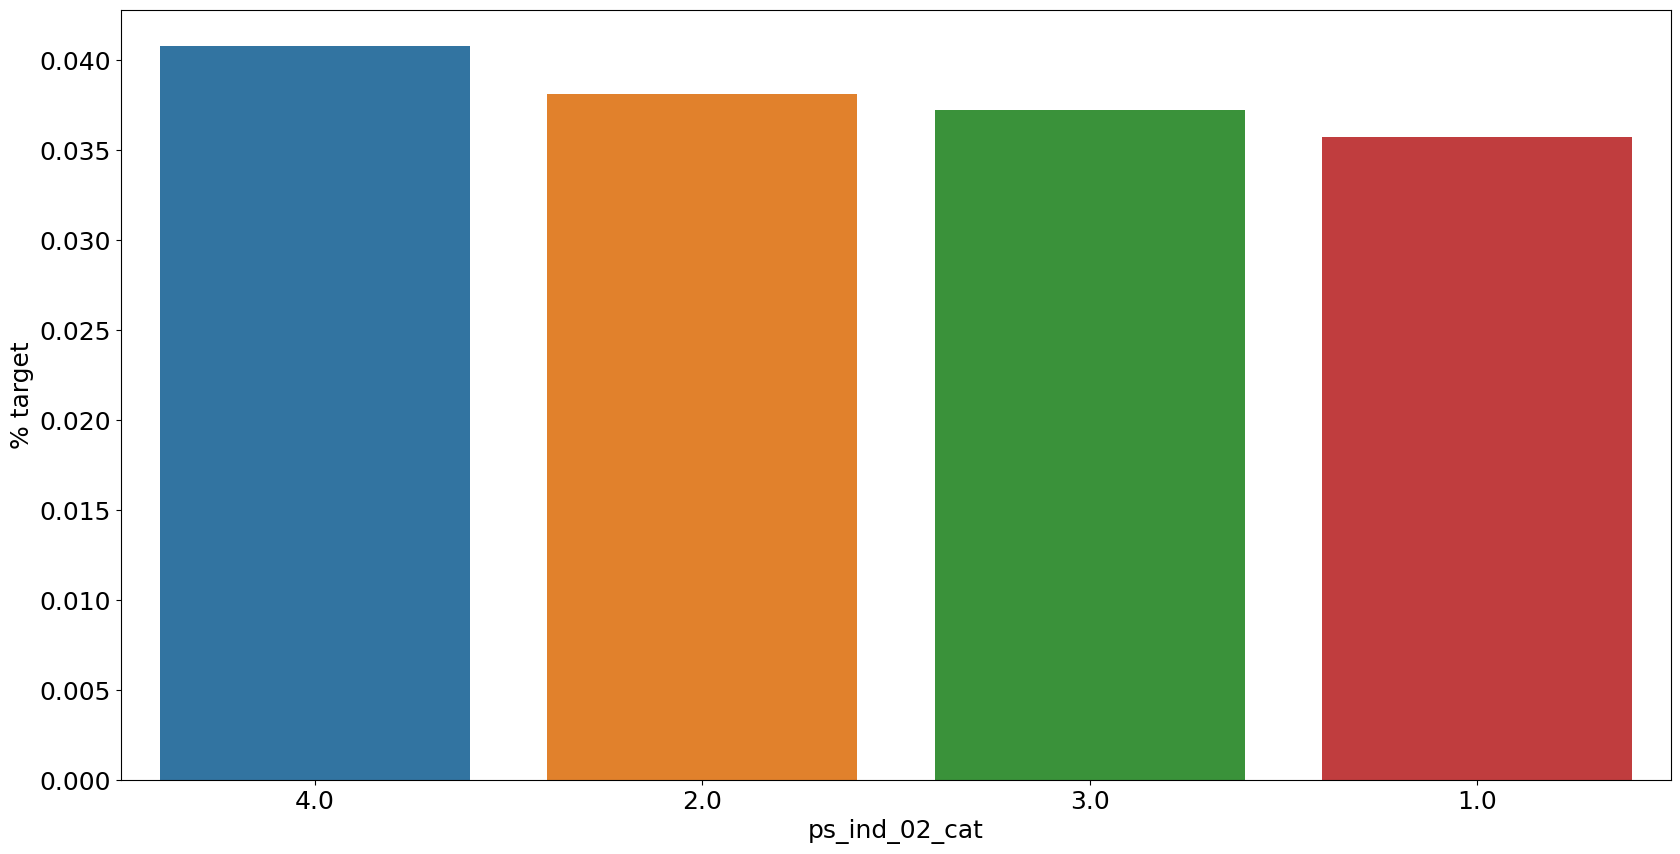

<Figure size 640x480 with 0 Axes>

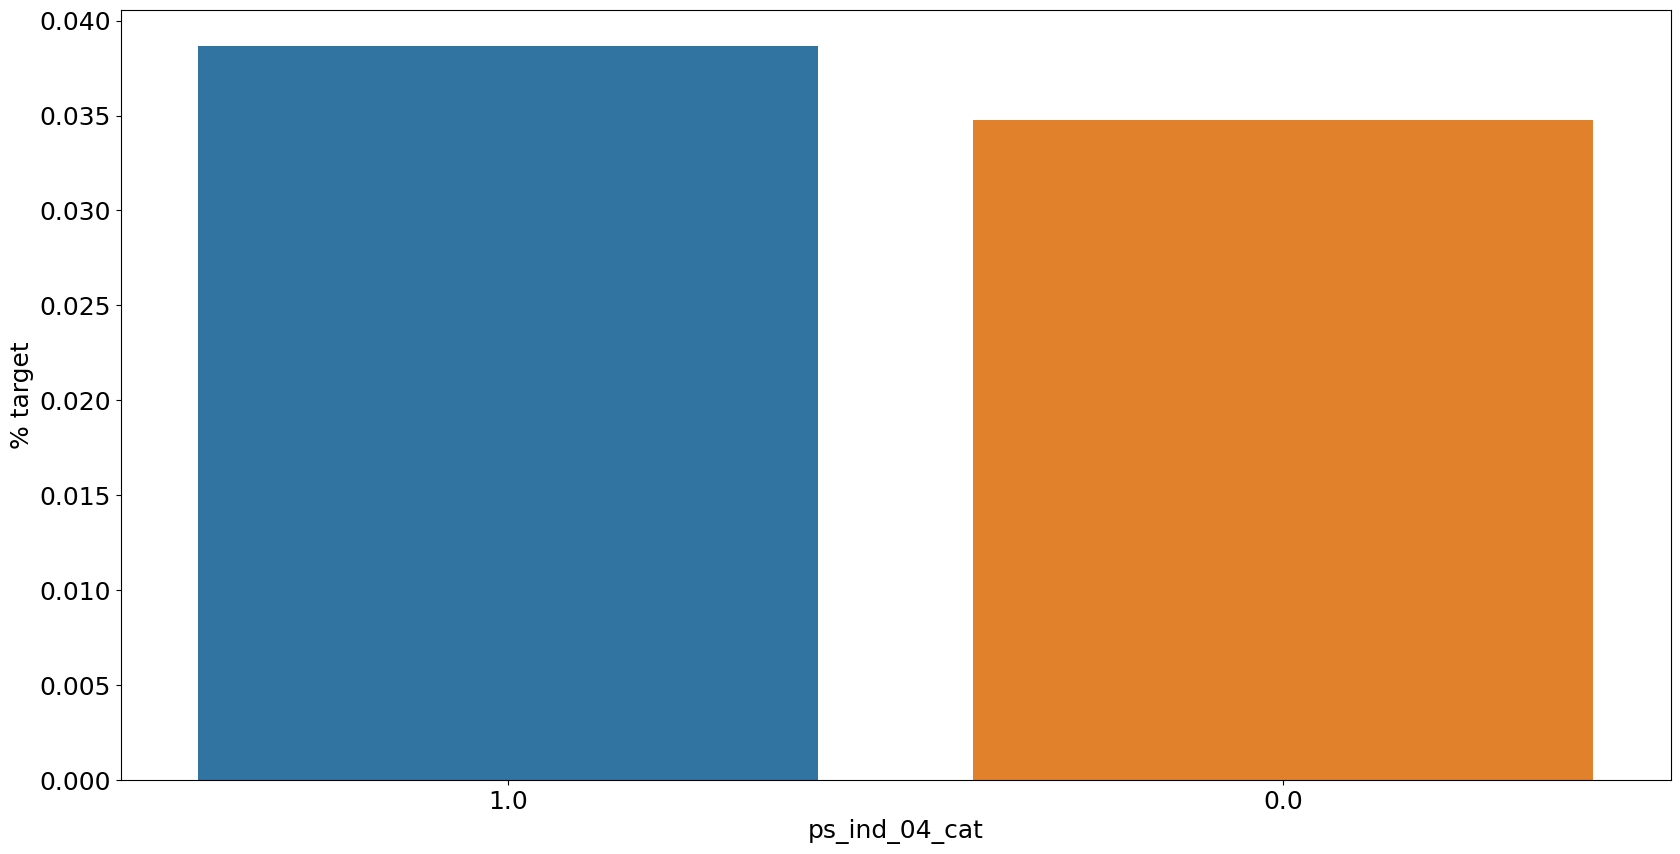

<Figure size 640x480 with 0 Axes>

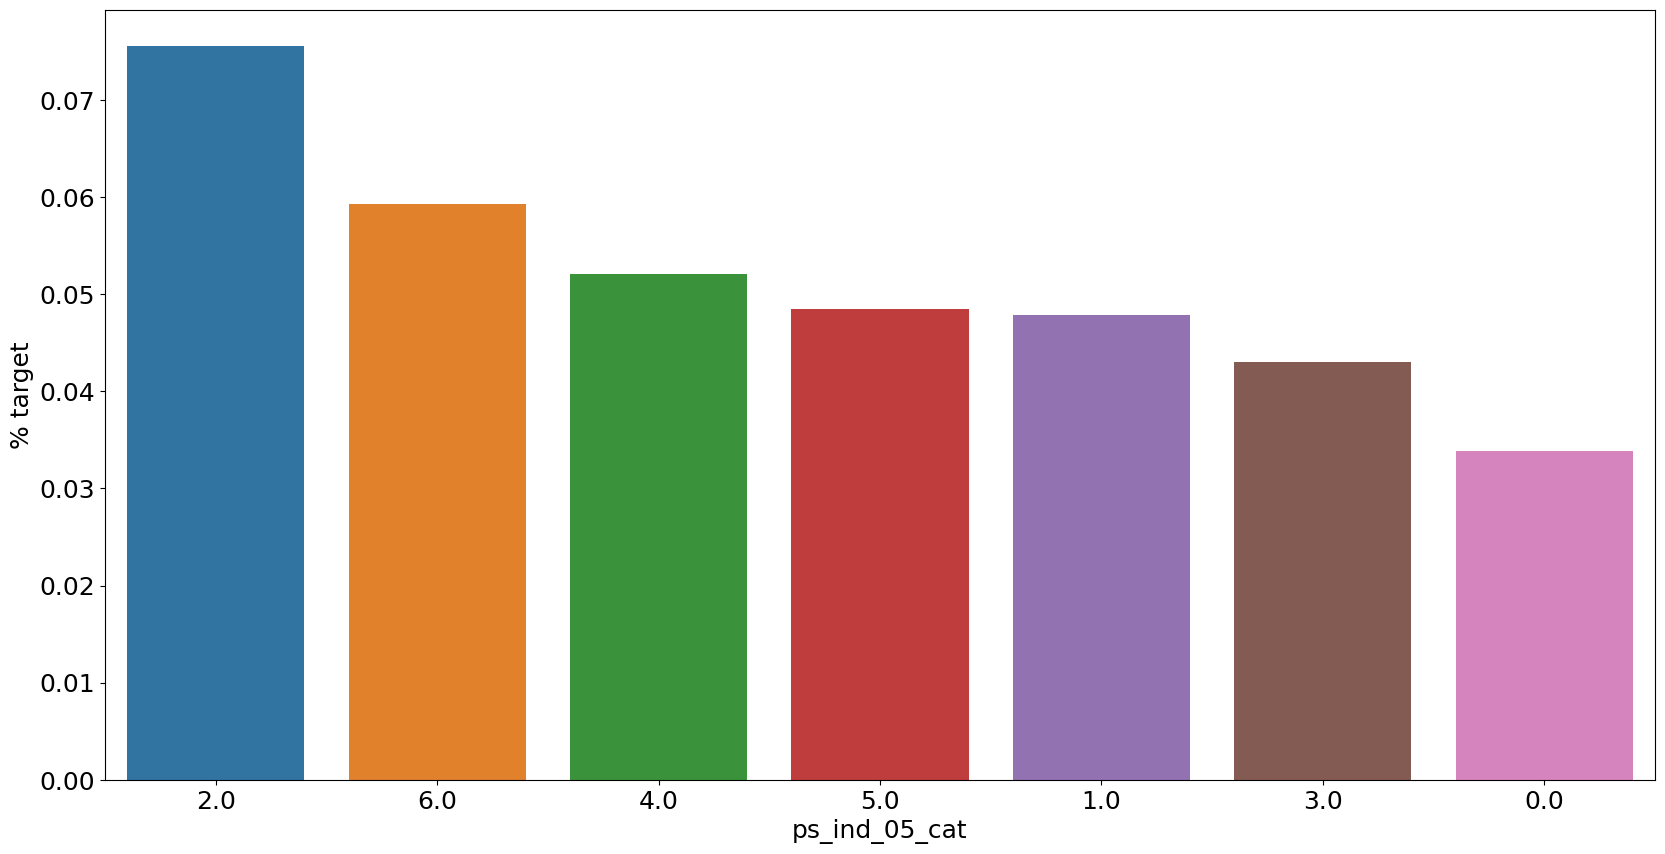

<Figure size 640x480 with 0 Axes>

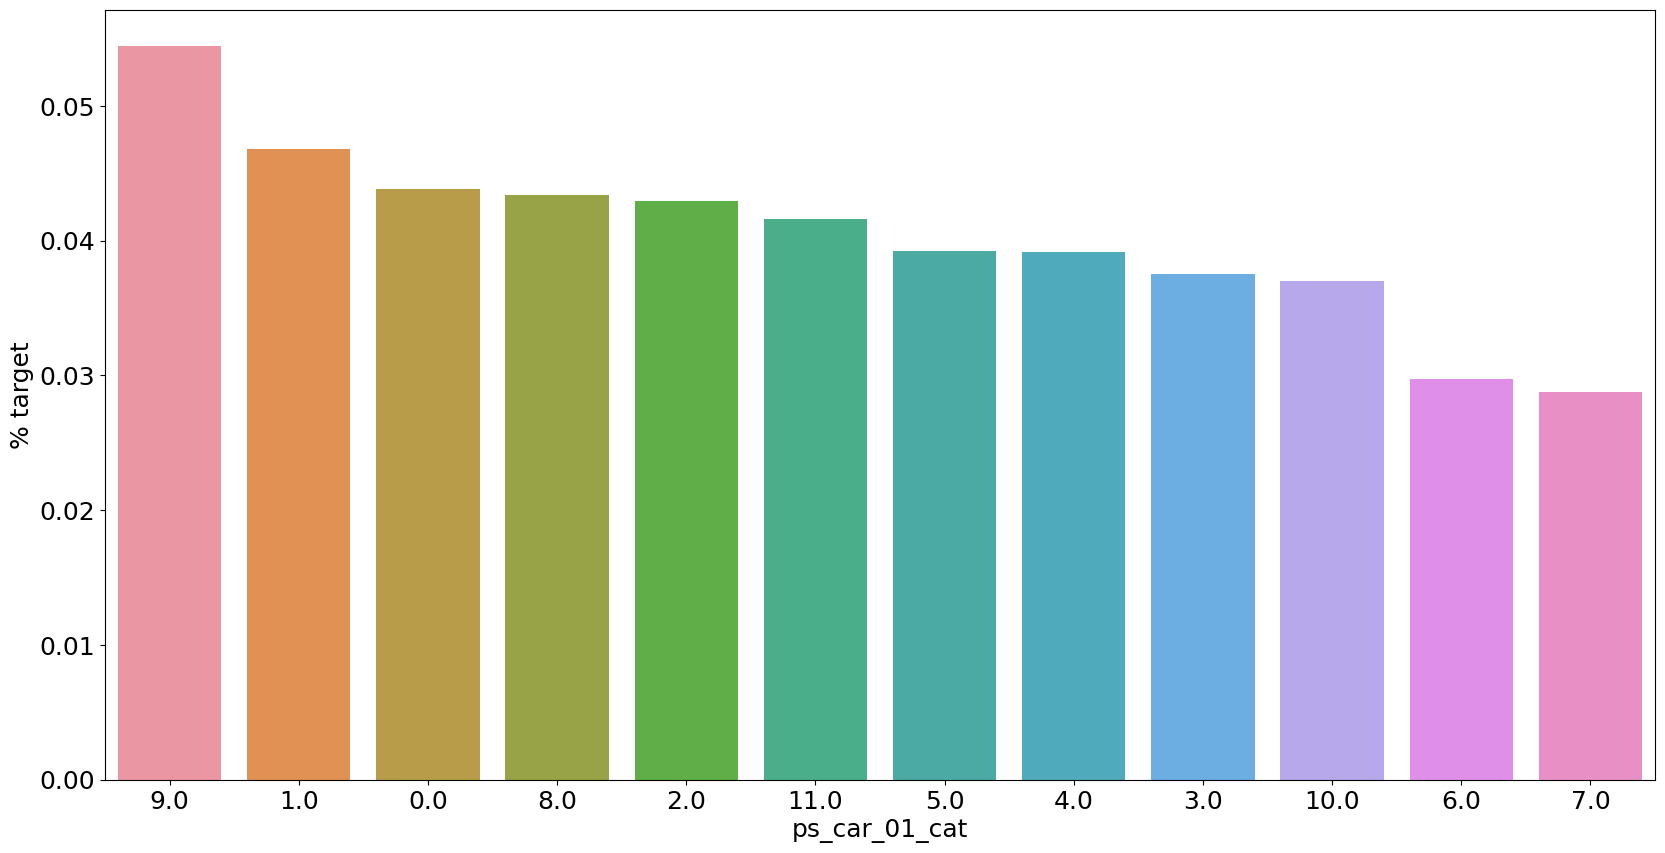

<Figure size 640x480 with 0 Axes>

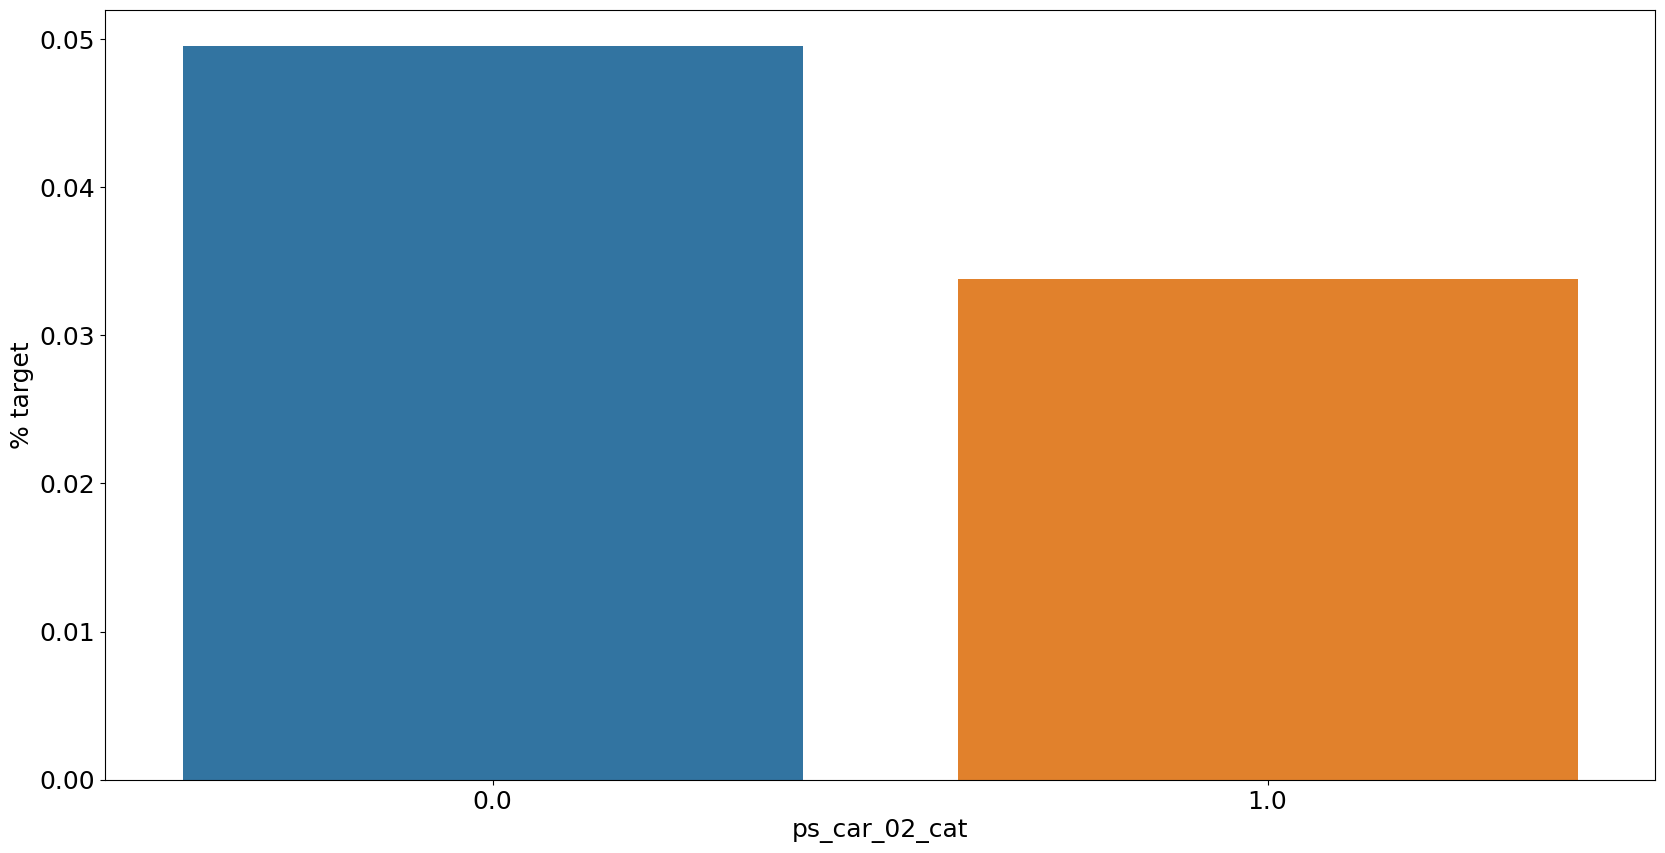

<Figure size 640x480 with 0 Axes>

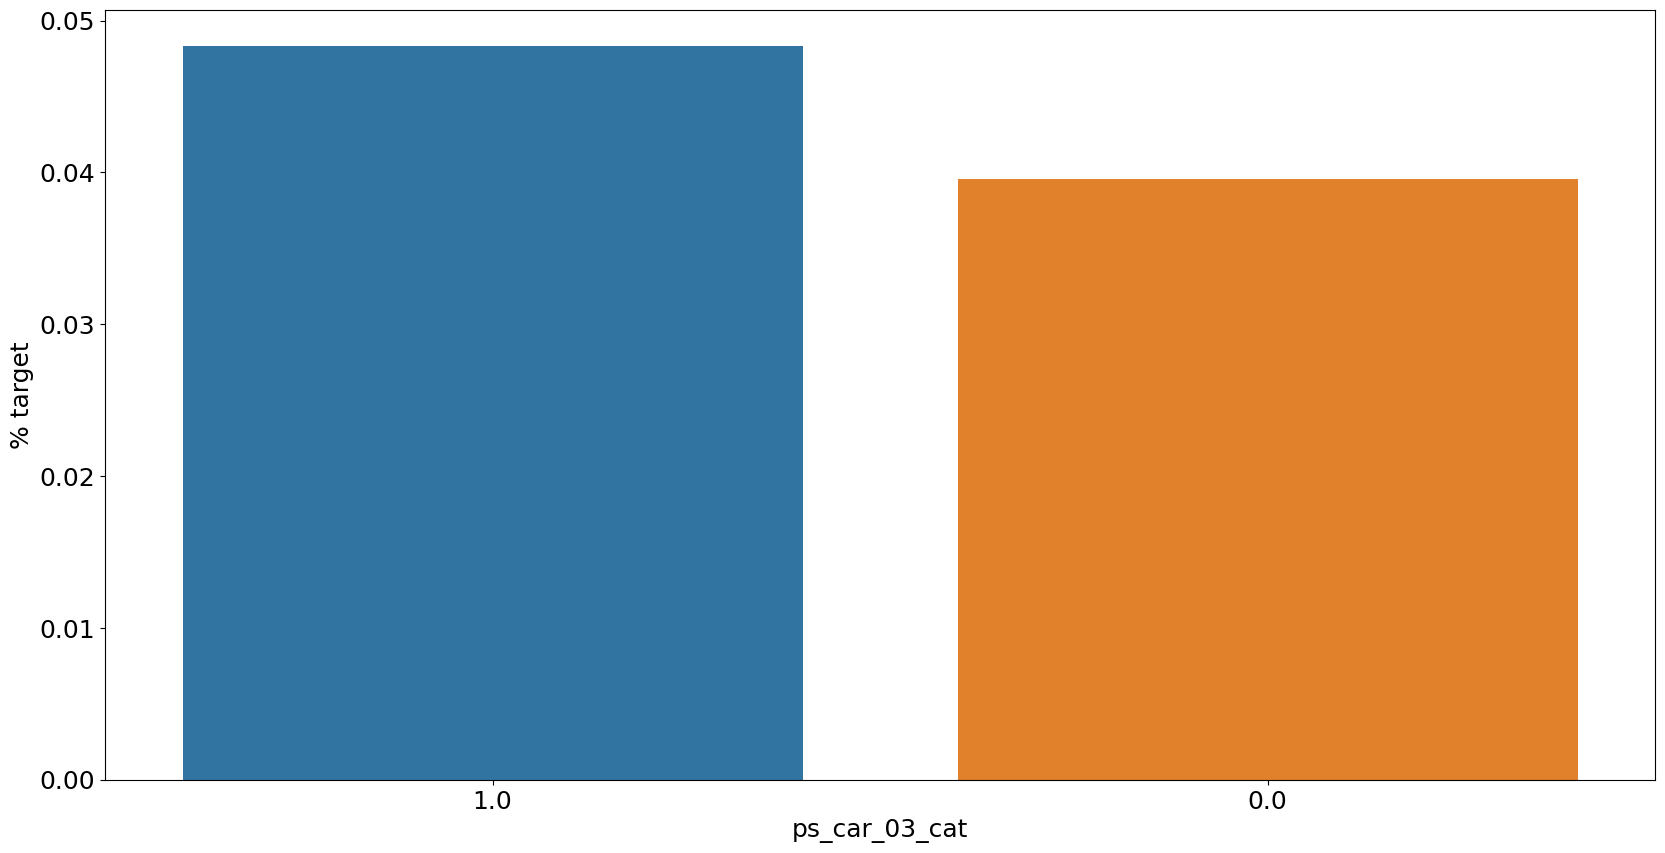

<Figure size 640x480 with 0 Axes>

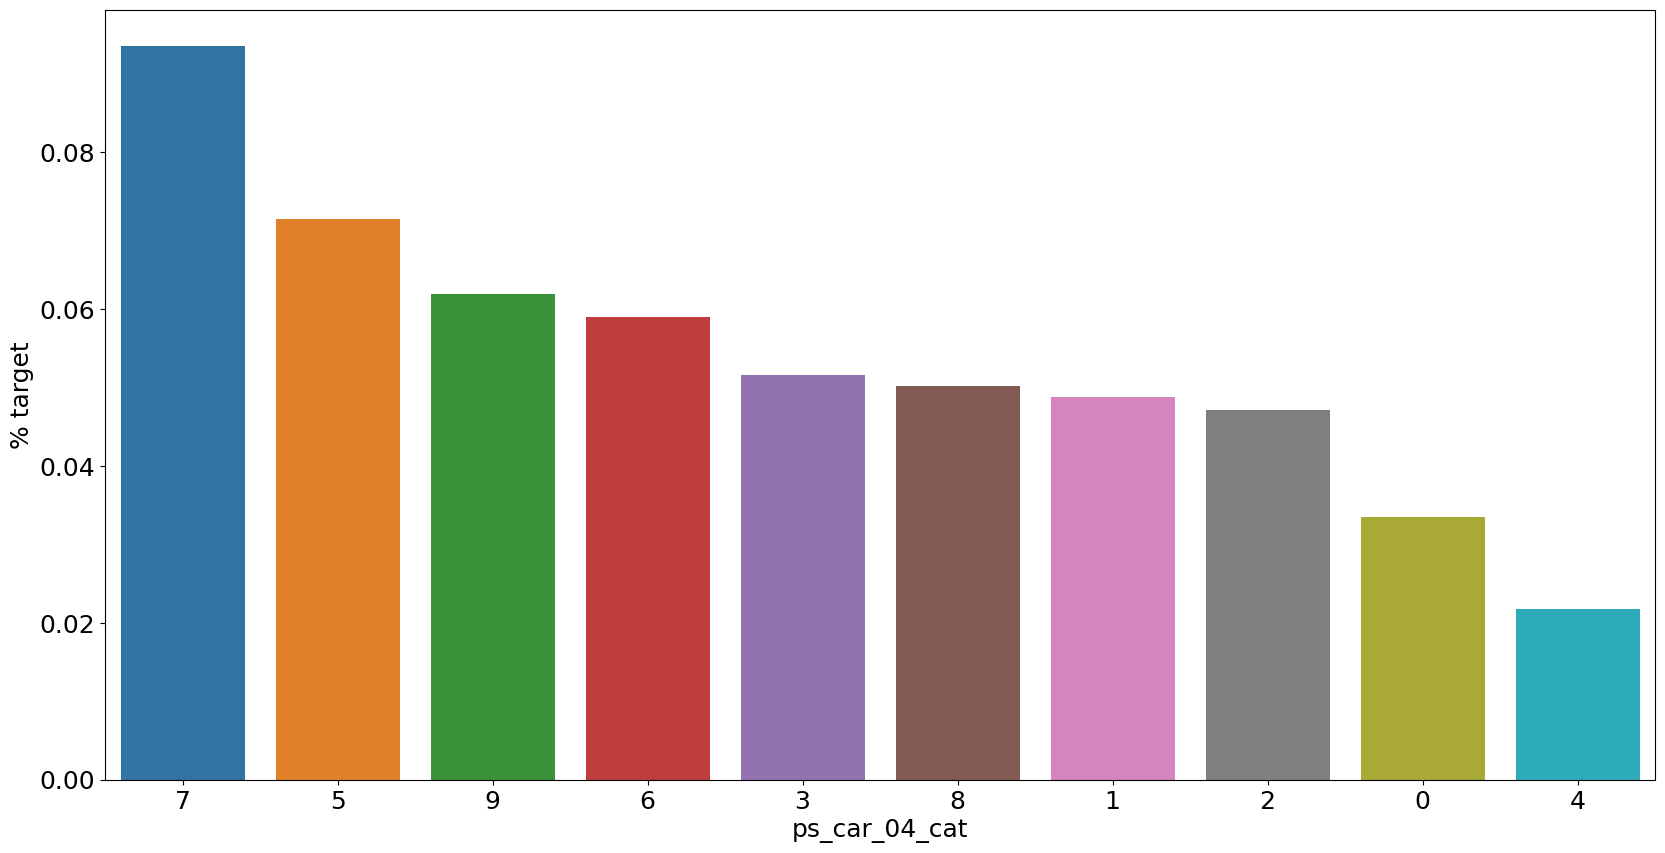

<Figure size 640x480 with 0 Axes>

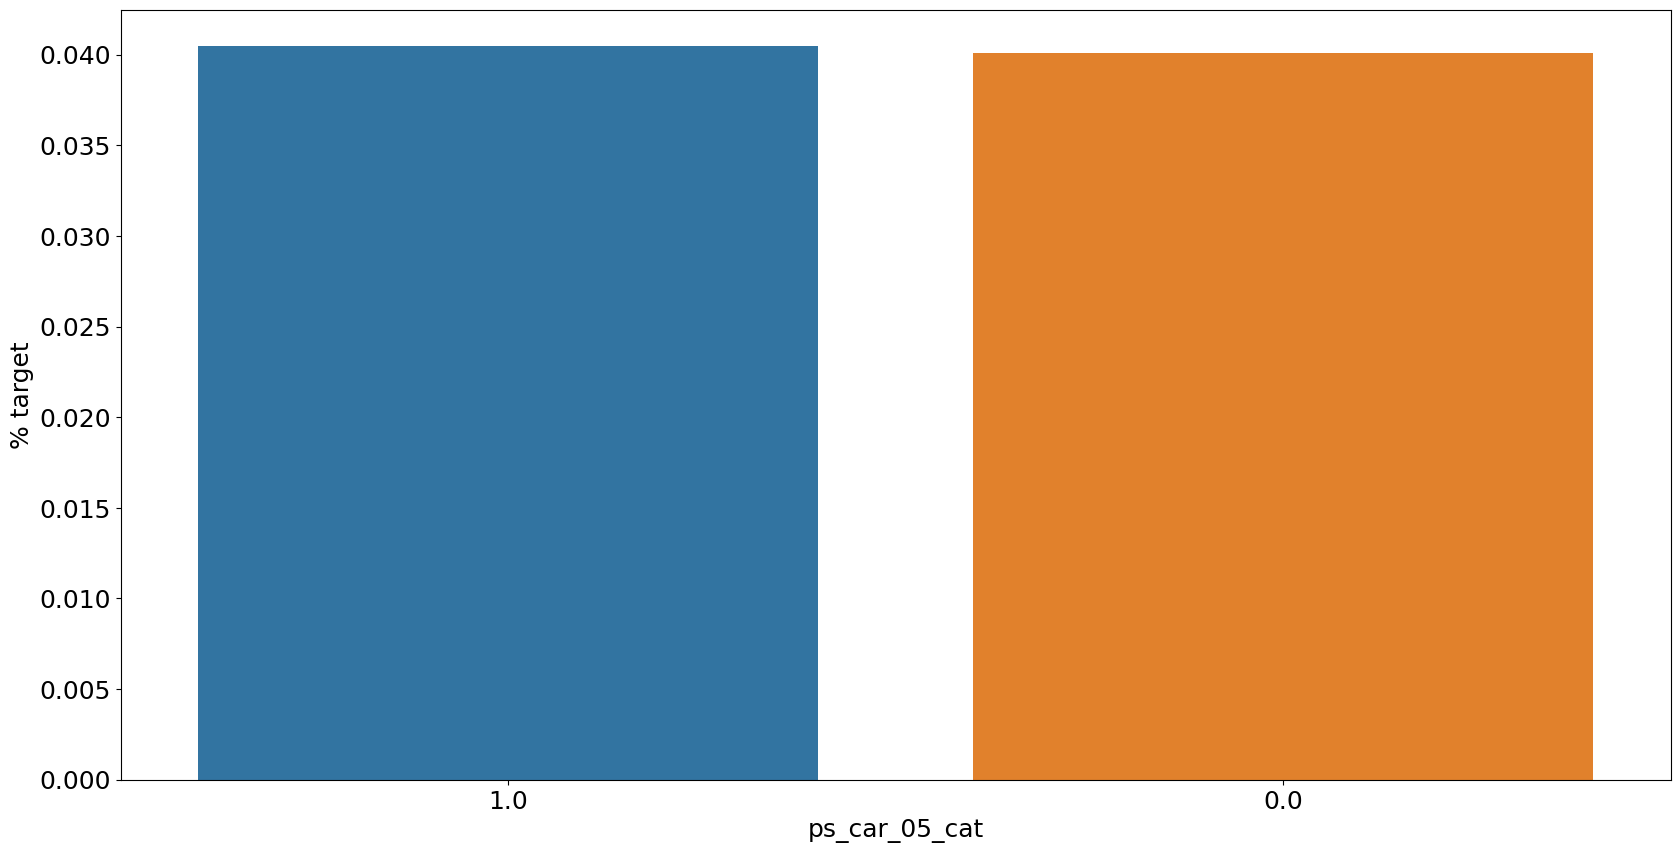

<Figure size 640x480 with 0 Axes>

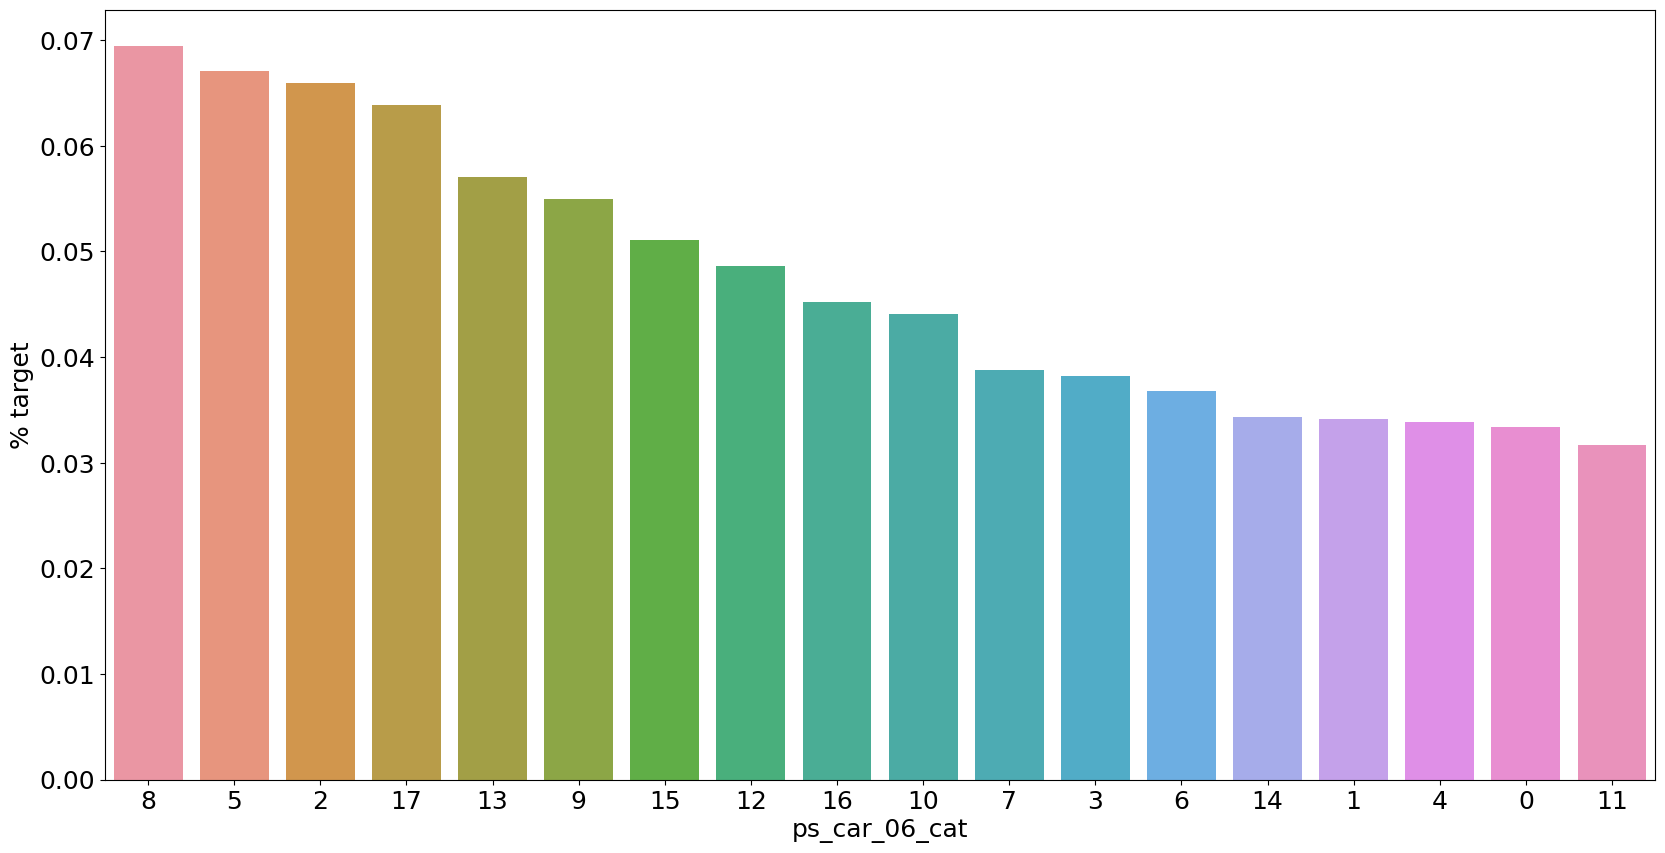

<Figure size 640x480 with 0 Axes>

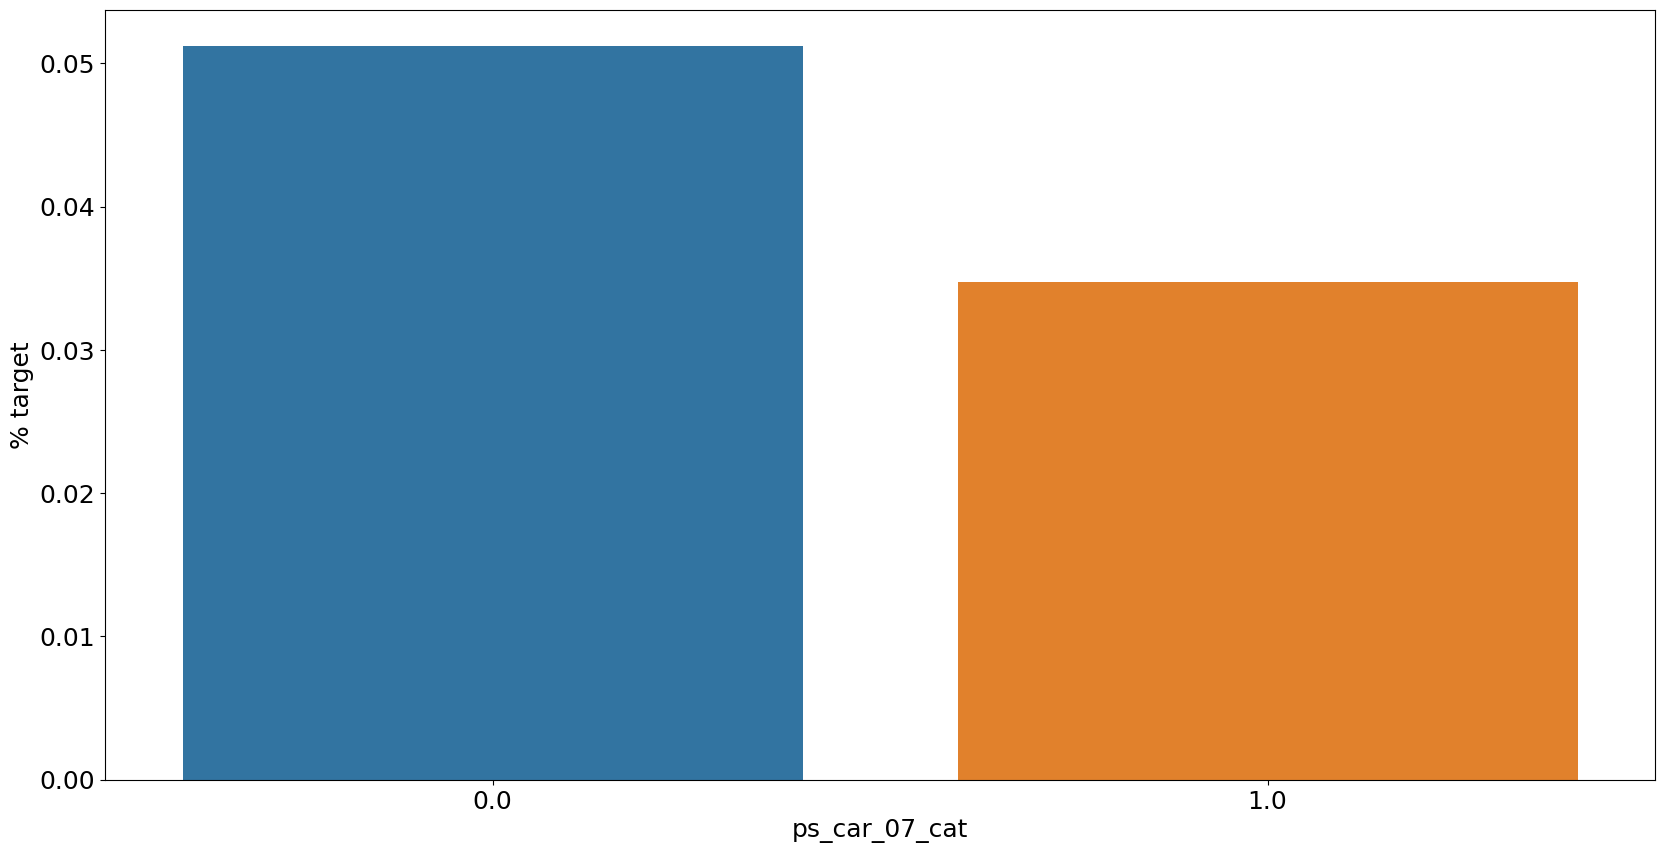

<Figure size 640x480 with 0 Axes>

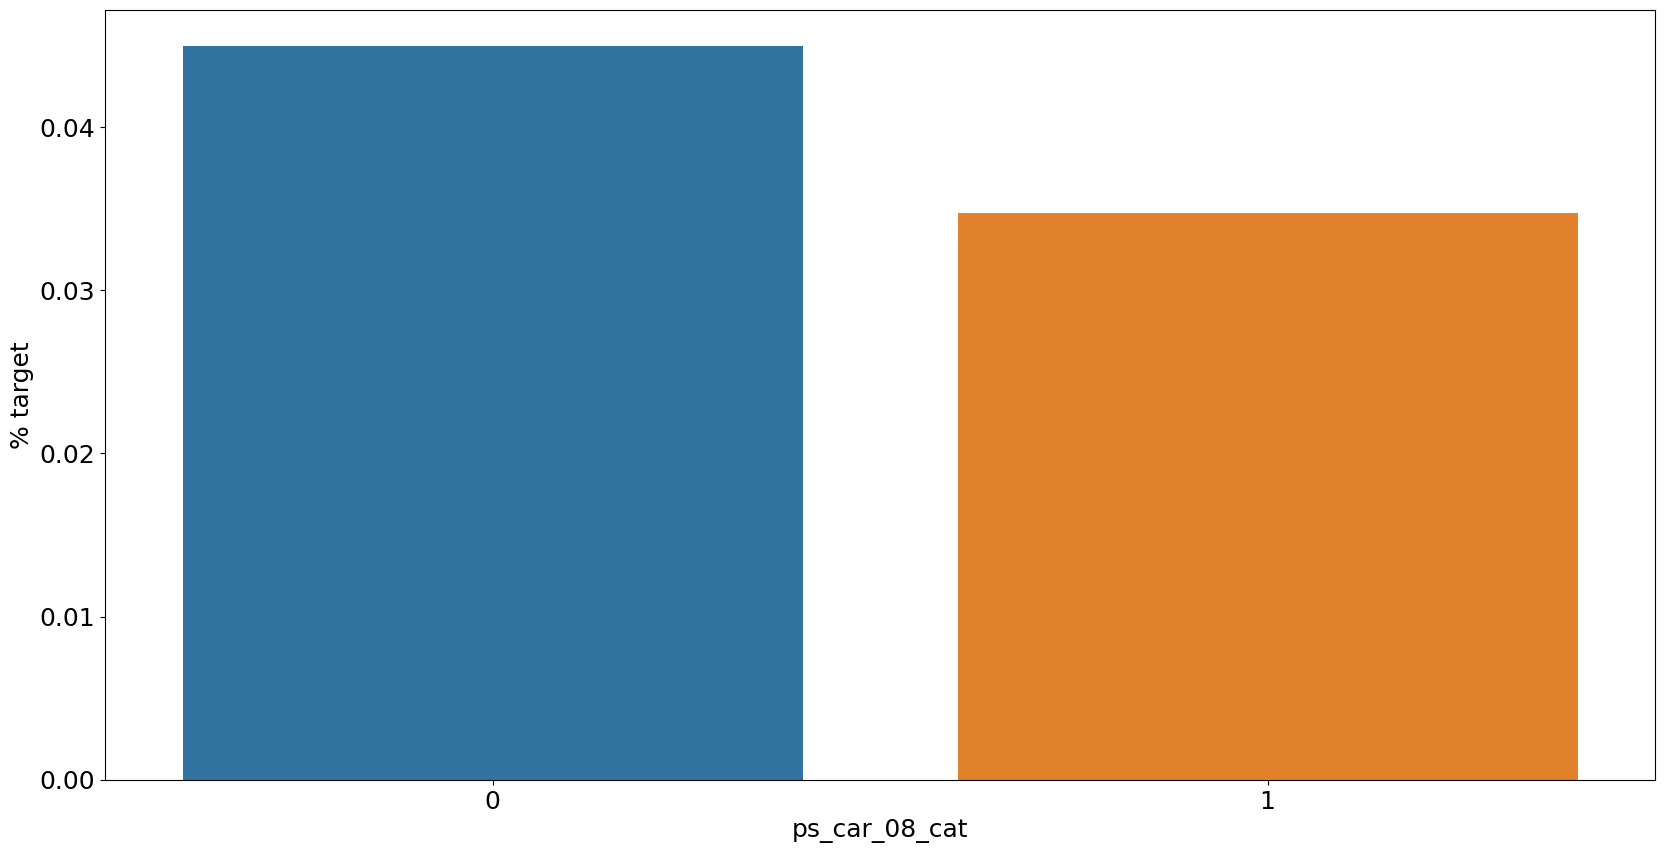

<Figure size 640x480 with 0 Axes>

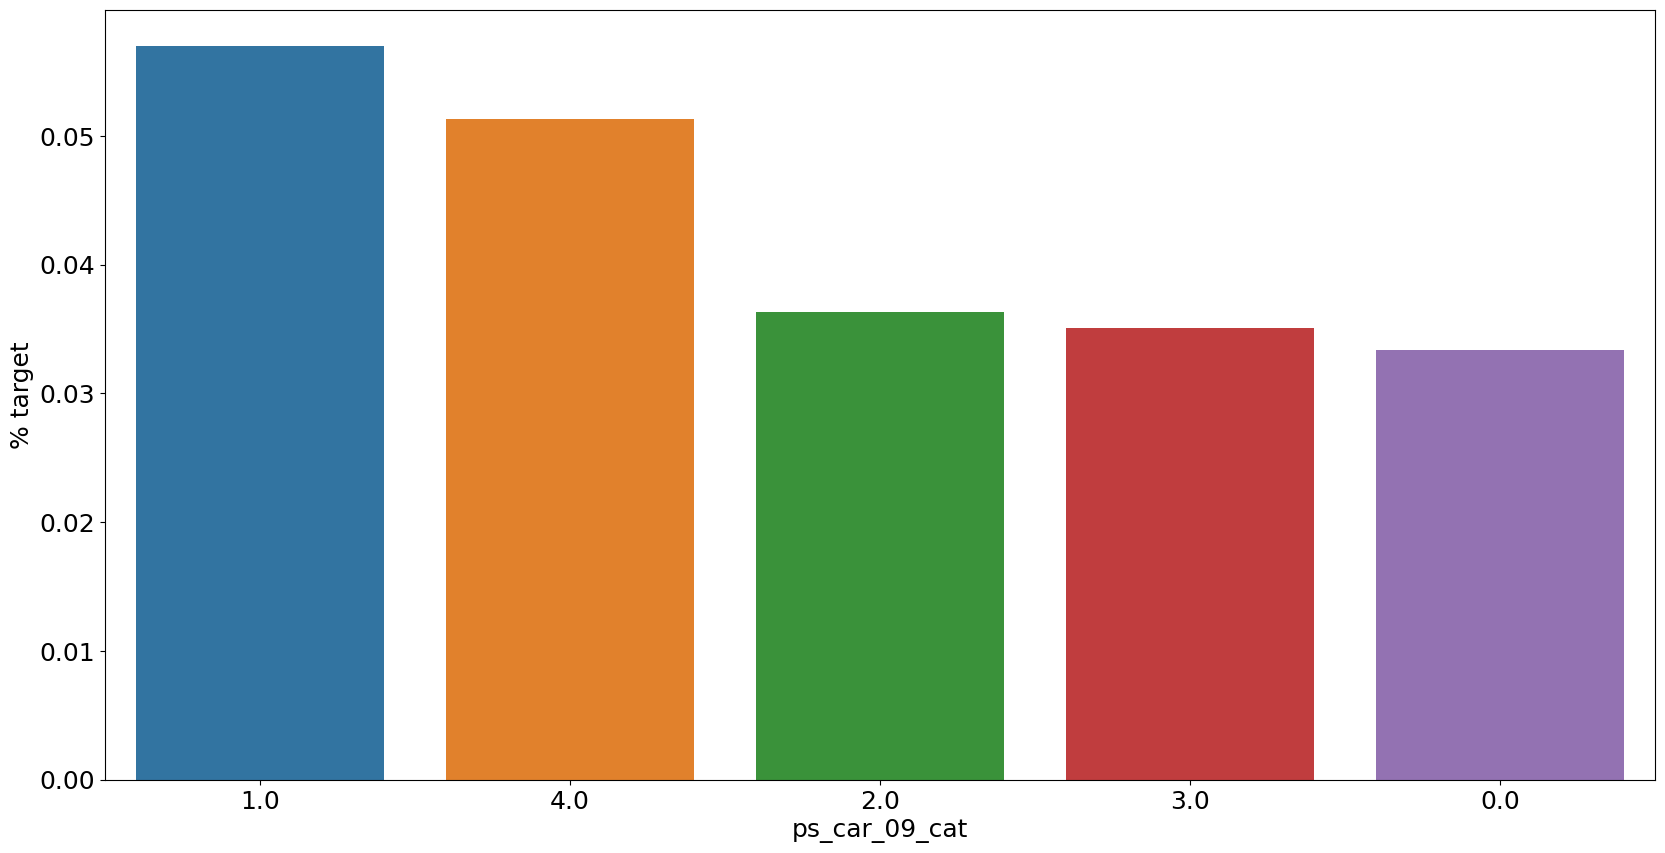

<Figure size 640x480 with 0 Axes>

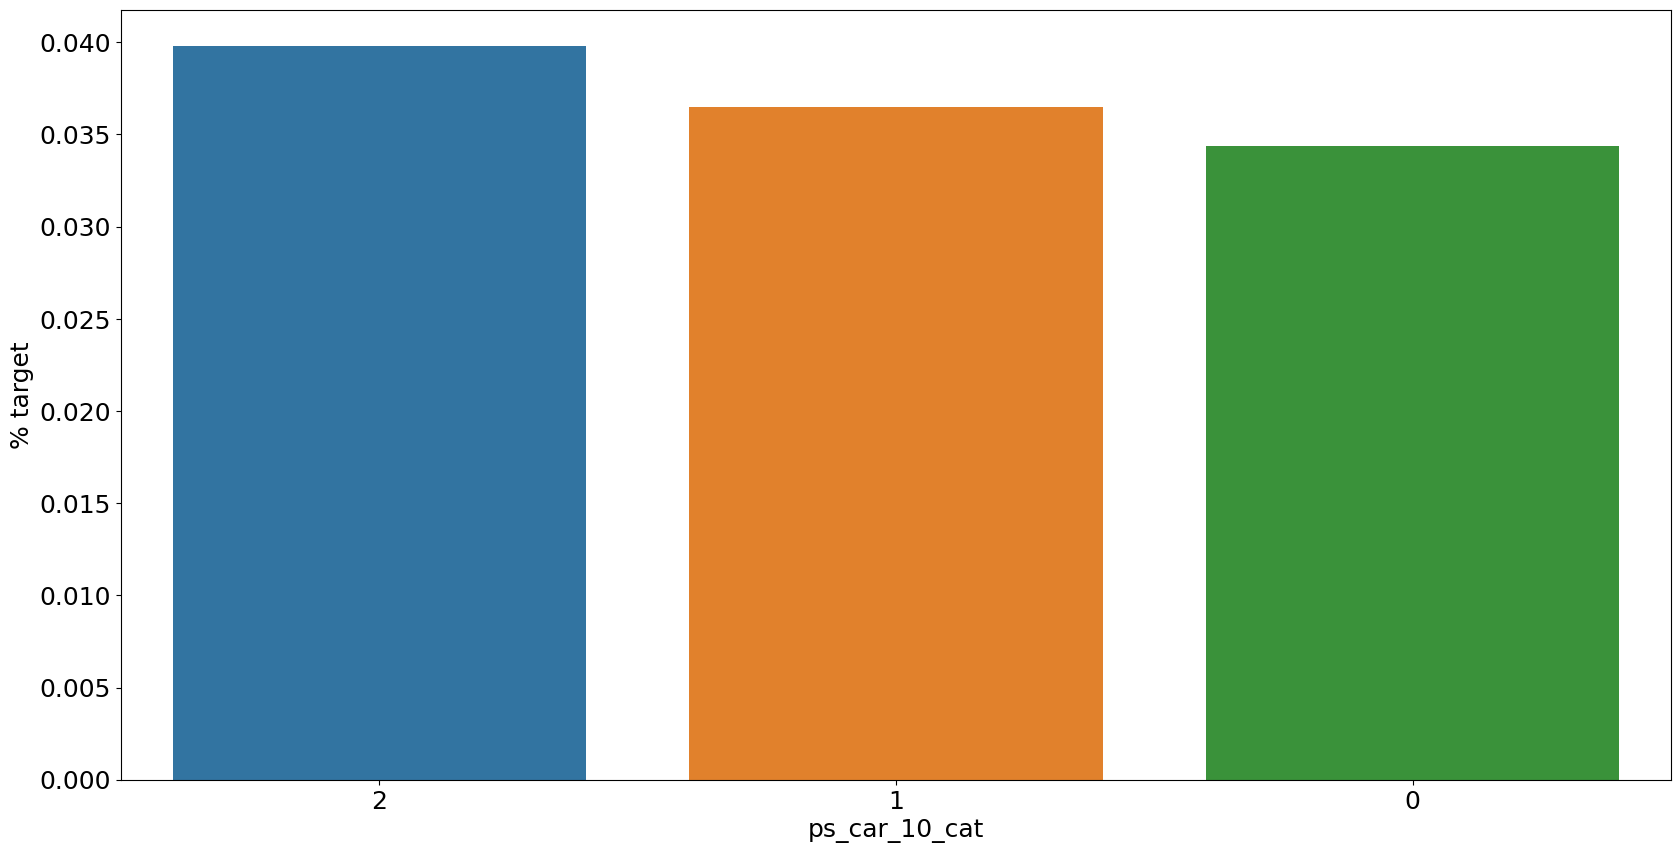

<Figure size 640x480 with 0 Axes>

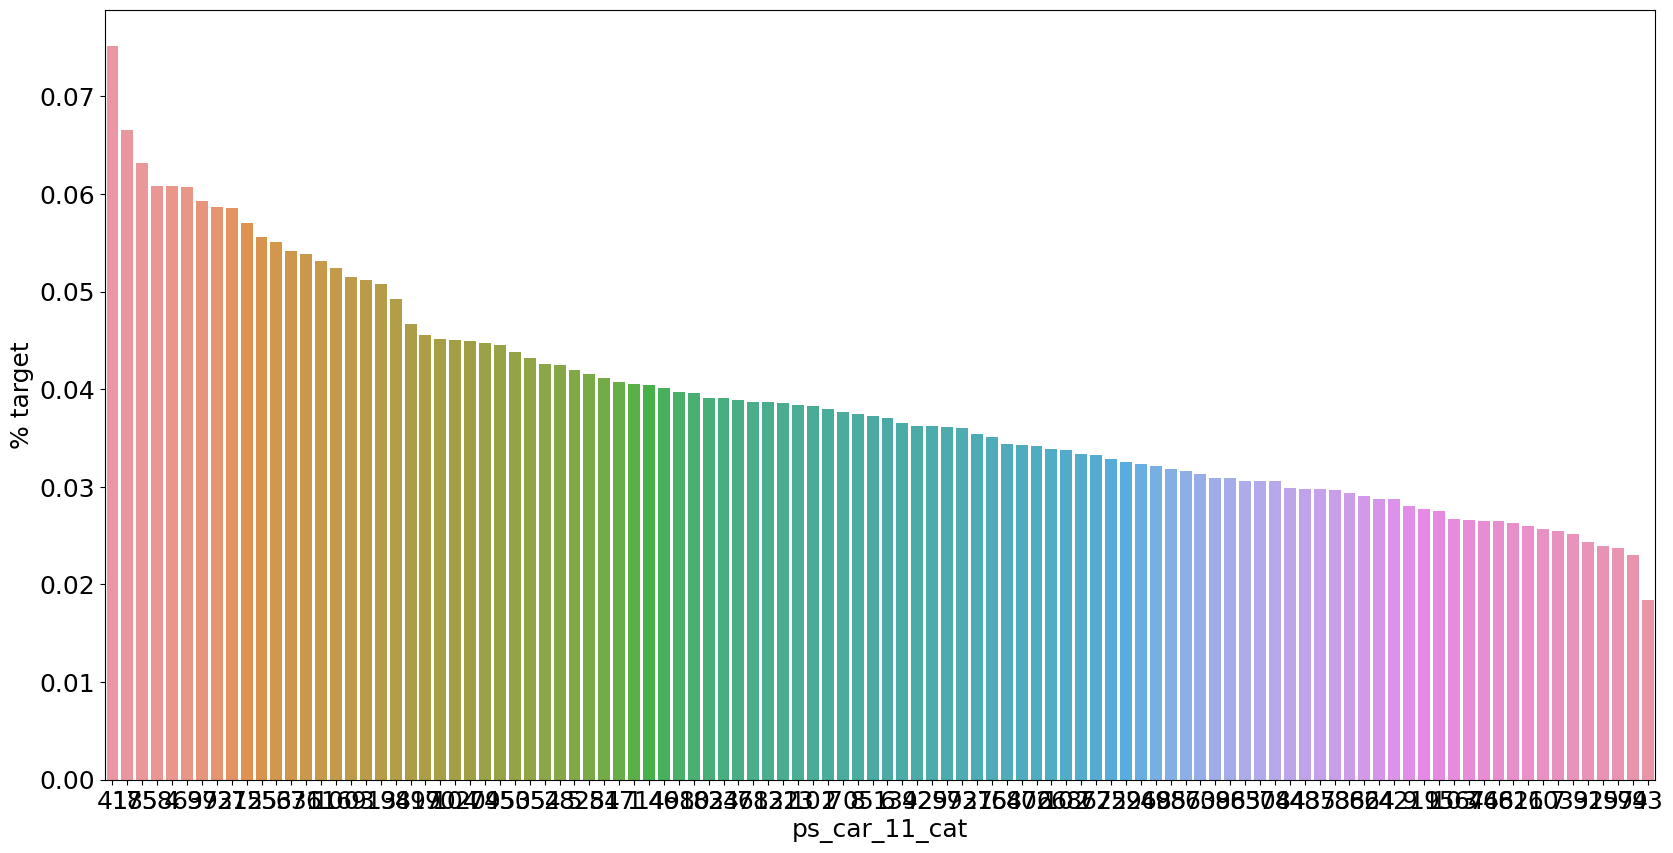

In [24]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    plt.figure()
    fig, ax = plt.subplots(figsize=(20,10))
    # Calculate the percentage of target=1 per category value
    
    cat_perc = train[[f, 'target']].groupby([f],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    # Bar plot
    # Order the bars descending on target mean
    sns.barplot(ax=ax, x=f, y='target', data=cat_perc, order=cat_perc[f])
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show()

## 間隔変数のチェック

区間変数間の相関を確認する。ヒートマップは、変数間の相関を可視化するよい方法である。
以下の変数間は強い相関がある

- ps_reg_02 and ps_reg_03: (0.7)
- ps_car_12 and ps_car13: (0.67)
- ps_car_12 and ps_car14: (0.58)
- ps_car_13 and ps_car15: (0.67)

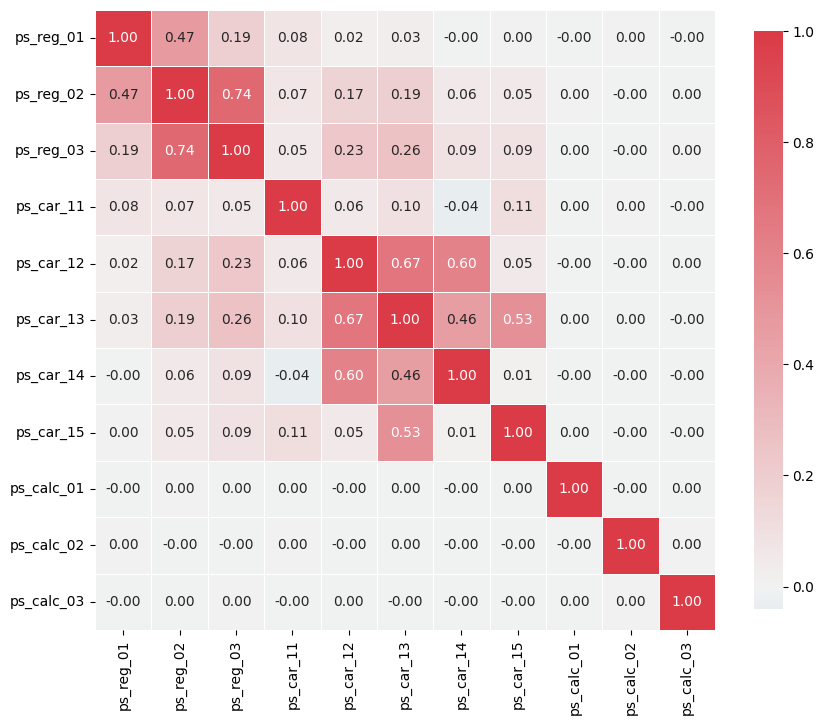

In [25]:
def corr_heatmap(v):
    correlations = train[v].corr()

    # Create color map ranging between two colors
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show();
    
v = meta[(meta.level == 'interval') & (meta.keep)].index
corr_heatmap(v)

In [26]:
s = train.sample(frac=0.1)

### ps_reg_02 and ps_reg_03

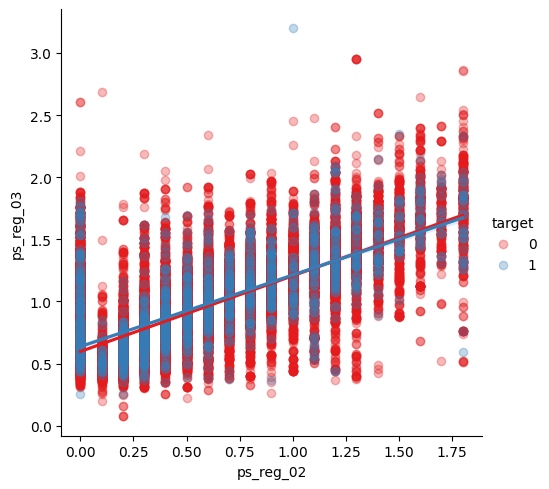

In [27]:
sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

### ps_car_12 and ps_car_13

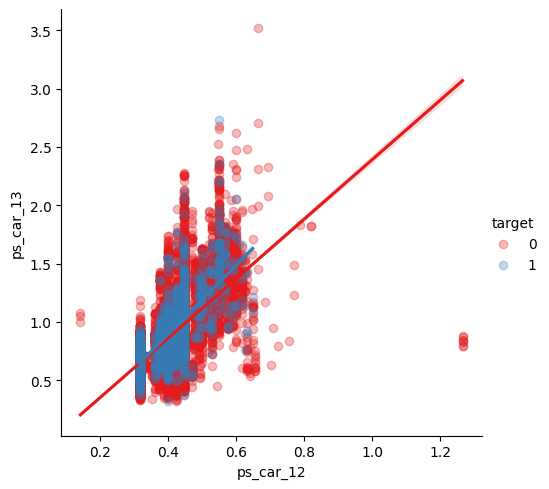

In [28]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

### ps_car_12 and ps_car_14

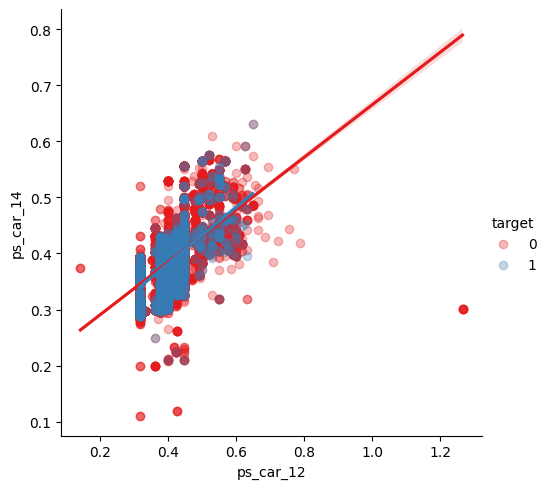

In [29]:
sns.lmplot(x='ps_car_12', y='ps_car_14', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

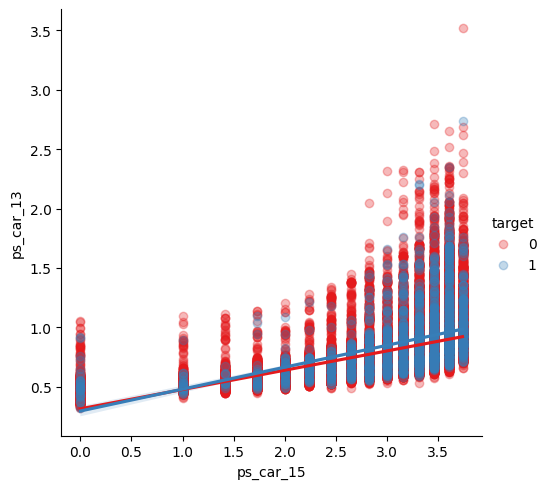

In [30]:
sns.lmplot(x='ps_car_15', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

相関のある変数のうち、どれを残すかをどうやって決めればいいのでしょうか？主成分分析(PCA)を実行して、次元を削減することができます。
AllState Claims Severity Competitionで、私はそれを行うためにこのカーネルを作りました。
しかし、相関のある変数の数はかなり少ないので、我々はモデルに力仕事をさせます。

# 特徴量エンジニアリング

In [31]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectFromModel

## 小島さんコードの前処理

### カラム毎の欠損値有無を特徴量として追加

In [32]:
def add_null_val_flag(df=None, cols_with_missing=None):
    # 欠損値を含む列を選択
    if cols_with_missing is None:
        cols_with_missing = df.columns[df.isnull().any()].tolist()
    print(cols_with_missing)

    # 欠損値があることを示すフラグ列を作成
    for col in cols_with_missing:
        df[col + '_missing'] = df[col].isnull().astype(int)

    return df,cols_with_missing

if IS_ADD_NULL_VAL_INFO:
    train, train_cols_with_missing = add_null_val_flag(train, None)
    test, _ = add_null_val_flag(test, train_cols_with_missing)

train.fillna(-1, inplace=True)
test.fillna(-1, inplace=True)

['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_05_cat', 'ps_car_07_cat', 'ps_car_09_cat', 'ps_car_11', 'ps_car_12', 'ps_car_14']
['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_05_cat', 'ps_car_07_cat', 'ps_car_09_cat', 'ps_car_11', 'ps_car_12', 'ps_car_14']


In [33]:
print(all(train.isnull().any().tolist()))
print(all(test.isnull().any().tolist()))

False
False


## 坂崎さんコードの前処理

In [34]:
#計算時間算出
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        #thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        #tmin, tsec = divmod(temp_sec, 60)
        #print('Time: %i H %i M %s sec' % (thour, tmin, round(tsec, 2)))
        tsec = (datetime.now() - start_time).total_seconds()
        print('Time:' + str(tsec))

#gini係数算出
# @jit
def gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n - 1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini


def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', gini(labels, preds), True

#未使用データ削除
#'ps_car_03_cat', 'ps_car_05_cat'欠損値多過ぎる、'ps_car_11_cat'カテゴリにしては多過ぎる
def dropmissingcol(pdData):
    # vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat','ps_car_11_cat']
    vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
    pdData.drop(vars_to_drop, inplace=True, axis=1)
    return pdData

#欠損値補完
def missingvalues(pdData):
    mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
    mode_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')#catは最頻値
    mode_col = ['ps_ind_02_cat','ps_ind_04_cat','ps_ind_05_cat',
                'ps_car_01_cat','ps_car_02_cat','ps_car_07_cat','ps_car_09_cat']
    pd_return = pdData.copy()
    features = pdData.columns
    for i in features:
        if i in mode_col:
            pd_return[i] = mode_imp.fit_transform(pdData[[i]]).ravel()
        else:
            pd_return[i] = mean_imp.fit_transform(pdData[[i]]).ravel()
    return pd_return

#カテゴリone-hot
def encodecat(train, test):
#    cat_features = [col for col in train.columns if '_cat' in col]
    cat_features = []
    for col in train.columns:
        if '_cat' in col:
            if len(col) < 15:
                cat_features.append(col)
    for column in cat_features:
        temp = pd.get_dummies(pd.Series(train[column]), prefix=column)
        train = pd.concat([train, temp], axis=1)
        train = train.drop([column], axis=1)

    for column in cat_features:
        temp = pd.get_dummies(pd.Series(test[column]), prefix=column)
        test = pd.concat([test, temp], axis=1)
        test = test.drop([column], axis=1)
    return train, test

#標準化
def RescaleData(train, test):
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(train)
    scaled_test = scaler.fit_transform(test)

    scaled_train = pd.DataFrame(scaled_train)
    scaled_test = pd.DataFrame(scaled_test)

    scaled_train.columns = train.columns
    scaled_test.columns = test.columns

    scaled_train.index = train.index
    scaled_test.index = test.index

    print(train.head())
    print(scaled_train.head())

    return scaled_train, scaled_test


#calc削除
def DropCalcCol(train, test):
    col_to_drop = train.columns[train.columns.str.startswith('ps_calc_')]
    train = train.drop(col_to_drop, axis=1)
    test = test.drop(col_to_drop, axis=1)
    return train, test

In [35]:
# データ確認
# x = np.shape(train)[0]
# y = np.shape(train)[1]
# train_columns = train.columns
# print('x = ' + str(x))
# print('y = ' + str(y))
# print(train_columns)

# 各種データ分割　データ系統ごと
train_target = train['target'].values
train_id = train['id'].values
test_id = test['id'].values

# 指定カラムの削除
train = dropmissingcol(train)
test = dropmissingcol(test)
# train = train.drop(['id','target'], axis=1)
# test = test.drop(['id'], axis=1)

train_cat_cols = []
train_bin_cols = []
train_num_cols = []
for col in train.columns:
    if '_cat' in col:
        train_cat_cols.append(col)
    elif '_bin' in col:
        train_bin_cols.append(col)
    else:
        train_num_cols.append(col)

train_cat = train[train_cat_cols]
train_bin = train[train_bin_cols]
train_num = train[train_num_cols]

test_cat_cols = []
test_bin_cols = []
test_num_cols = []
for col in test.columns:
    if '_cat' in col:
        test_cat_cols.append(col)
    elif '_bin' in col:
        test_bin_cols.append(col)
    else:
        test_num_cols.append(col)

test_cat = test[test_cat_cols]
test_bin = test[test_bin_cols]
test_num = test[test_num_cols]

# trainデータ選択
train_temp = train_cat
test_temp = test_cat
train_temp = pd.concat([train_cat, train_num, train_bin], axis=1)
test_temp = pd.concat([test_cat, test_num, test_bin], axis=1)

# 欠損値補完
X = missingvalues(train_temp)
X_test = missingvalues(test_temp)
X = pd.DataFrame(X)
X_test = pd.DataFrame(X_test)

# calc削除、on-hot、正規
X, X_test = DropCalcCol(X, X_test)
X, X_test = encodecat(X, X_test)
X, X_test = RescaleData(X, X_test)

# ラベル設定
y = X.target.values

   ps_ind_02_cat_missing  ps_ind_04_cat_missing  ps_ind_05_cat_missing  \
0                    0.0                    0.0                    0.0   
1                    0.0                    0.0                    0.0   
2                    0.0                    0.0                    0.0   
3                    0.0                    0.0                    0.0   
4                    0.0                    0.0                    0.0   

   ps_car_01_cat_missing  ps_car_02_cat_missing  ps_car_03_cat_missing  \
0                    0.0                    0.0                    1.0   
1                    0.0                    0.0                    1.0   
2                    0.0                    0.0                    1.0   
3                    0.0                    0.0                    0.0   
4                    0.0                    0.0                    1.0   

   ps_car_05_cat_missing  ps_car_07_cat_missing  ps_car_09_cat_missing    id  \
0                    0.0      

In [36]:
# 単純データ数削減
if REDUCE_TRAINS:
    train_num = 50000
    X = X.loc[:train_num - 1]
    y = np.delete(y,range(train_num,len(y)),0)

## 単純アンダーサンプリング

ref. https://www.kaggle.com/code/rafjaa/resampling-strategies-for-imbalanced-datasets/notebook

In [37]:
# Get indices per class
cls_0_indices, cls_1_indices = np.where(y==0)[0], np.where(y==1)[0]
df_class_0 = X.iloc[cls_0_indices]
df_class_1 = X.iloc[cls_1_indices]

count_class_0, count_class_1 = list(map(len, [cls_0_indices, cls_1_indices]))
print(f'count_class_0: {count_class_0}')
print(f'count_class_1: {count_class_1}')

count_class_0: 0
count_class_1: 0


In [38]:
if SIMPLE_UNDER_SAMPLE:
    df_class_0_under = df_class_0.sample(count_class_1)
    df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

    print('Random under-sampling:')
    print(df_test_under.target.value_counts())
    df_test_under.target.value_counts().plot(kind='bar', title='Count (target)')

    X = df_test_under
    y = y.iloc[df_test_under.index]

## ダミー変数(One-Hot Encoding)の作成

カテゴリ変数の値は、いかなる順序や大きさも表さない。例えば、カテゴリ2はカテゴリ1の2倍の値ではありません。したがって、我々はそれに対処するためにダミー変数を作成することができます。この情報は、元の変数のカテゴリに対して生成された他のダミー変数から得られるので、我々は最初のダミー変数を削除します。

In [39]:
def OneHotEncode(train, test, drop_cols):
    v = meta[(meta.level == 'nominal') & (meta.keep)].index
    print('Before dummification we have {} variables in train'.format(src.shape[1]))
    df = pd.get_dummies(src, columns=v, drop_first=True)
    print('After dummification we have {} variables in train'.format(src.shape[1]))

    return df

if DUMMIFICATION:
    v = meta[(meta.level == 'nominal') & (meta.keep)].index
    print('Before dummification we have {} variables in train'.format(train.shape[1]))
    train = pd.get_dummies(train, columns=v, drop_first=True)
    print('After dummification we have {} variables in train'.format(train.shape[1]))

# マージ対応中
# if DUMMIFICATION:
#     v = meta[(meta.level == 'nominal') & (meta.keep)].index
#     drop_cols = []
#     drop_cols, prefix = [c for c in v]
#     for c in v:
#         if df[c].nunique() > 2:
#             c2.append(c)
#             c3[c] = 'ohe_'+c
#     train, test = OneHotEncode(train, test, drop_cols)

## ターゲットエンコーディング

In [40]:
# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [41]:
if TARGET_ENCODE:

    train_encoded, test_encoded = target_encode(train["ps_car_11_cat"], 
                                 test["ps_car_11_cat"], 
                                 target=train.target, 
                                 min_samples_leaf=100,
                                 smoothing=10,
                                 noise_level=0.01)

    train['ps_car_11_cat_te'] = train_encoded
    train.drop('ps_car_11_cat', axis=1, inplace=True)
    meta.loc['ps_car_11_cat','keep'] = False  # Updating the meta
    test['ps_car_11_cat_te'] = test_encoded
    test.drop('ps_car_11_cat', axis=1, inplace=True)

## 相互特徴量の作成

相互作用の効果は、相互作用する特徴量の対応する値の積からなる新しい特徴量を含めることによって説明することができる。

In [42]:
if POLYNOMIAL:
    v = meta[(meta.level == 'interval') & (meta.keep)].index
    poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
    interactions = pd.DataFrame(data=poly.fit_transform(train[v]), columns=poly.get_feature_names_out(v))
    interactions.drop(v, axis=1, inplace=True)  # Remove the original columns
    # Concat the interaction variables to the train data
    print('Before creating interactions we have {} variables in train'.format(train.shape[1]))
    train = pd.concat([train, interactions], axis=1)
    print('After creating interactions we have {} variables in train'.format(train.shape[1]))

## 特徴選択

個人的には、どの特徴を残すかは、分類器のアルゴリズムに任せるのがいいと思います。
しかし、1つだけ私たち自身でできることがあります。それは、分散がない、あるいは非常に小さい特徴を削除することです。
Sklearnにはそれを行うための便利なメソッドがあります。VarianceThresholdです。
デフォルトでは、分散がゼロの素性を削除します。これまでのステップで分散ゼロの変数がないことを確認したので、これは今回のコンペティションには適用されないでしょう。
しかし、もし1%未満の分散を持つ特徴を削除すると、31個の変数を削除することになります。

### 分散による特徴量選択

分散に基づいて選択すると、むしろ多くの変数を失うことになります。しかし、我々はそれほど多くの変数を持っていないので、分類器に選択させることにします。多くの変数があるデータセットでは、処理時間を短縮することができます。

In [43]:
if VARIANCE_THRESH:
    selector = VarianceThreshold(threshold=.01)
    selector.fit(train.drop(['id', 'target'], axis=1)) # Fit to train without id and target variables

    f = np.vectorize(lambda x : not x) # Function to toggle boolean array elements

    v = train.drop(['id', 'target'], axis=1).columns[f(selector.get_support())]
    print('{} variables have too low variance.'.format(len(v)))
    print('These variables are {}'.format(list(v)))

### ラッパー法による特徴選択

In [44]:
from sklearn.model_selection import train_test_split
if WRAPPER_METHOD:
    #データ分割
    X_train, X_val, Y_train, Y_val= train_test_split(X, y_train, test_size=0.10)

    feature = X_train.shape[1]
    print(feature)
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    #sfs = SFS(LinearRegression(),　　　　　　　　　　　　　　　　　　　#LR
    sfs = SFS(LGBMClassifier(n_estimators=1200, alpha=0.02),         #LGBM
            k_features=feature,
            forward=True,
            floating=False,
            scoring = 'neg_mean_squared_error',
            cv = skf)
    sfs.fit(X_train,Y_train)
    df_SFS_results = pd.DataFrame(sfs.subsets_).transpose()
    df_SFS_results['avg_score'] = df_SFS_results["avg_score"].astype(float)
    df_SFS_results
    #df_SFS_results.to_csv('df_SFS_results_LGBM.csv') #結果保存

In [45]:
# 不要カラム削除
X = X.drop(['id','target'], axis=1)
X_test = X_test.drop(['id'], axis=1)

# モデリング

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBRFClassifier

Models = {
    "LR":   LinearRegression,           # 線形回帰
    # "KNN":  KNeighborsClassifier,       # k近傍分類
    # "SV":   SVC,                        # サポートベクター
    # "DT":   DecisionTreeClassifier,     # 決定木
    # "RF":   RandomForestClassifier,     # ランダムフォレスト
    "XGB":  XGBRFClassifier,            # XGBoost   
    # "GBDT": GradientBoostingClassifier, # 勾配ブースティング
    "LGBM": LGBMClassifier              # LightGBM
}

## Hyperparameters

In [47]:
lr_params = {}
knnr_params = {}
svr_params = {}
dt_params = {}
rf_params = {'n_estimators': 625}
xgb_params = {'n_estimators': 550}
gbdt_params = {'n_estimators': 4000}
lgbm_params = {'n_estimators': 1200}

hparam_list = {
    "LR": lr_params,
    "KNN": knnr_params,
    "SV": svr_params,
    "DT": dt_params,
    "RF": rf_params,
    "XGB": xgb_params,
    "GBDT": gbdt_params,
    "LGBM": lgbm_params
}

# xgb_params = {
#     'min_child_weight': 10.0,
#     'objective': 'binary:logistic',
#     'max_depth': 7,
#     'max_delta_step': 1.8,
#     'colsample_bytree': 0.4,
#     'subsample': 0.8,
#     'eta': 0.025,
#     'gamma': 0.65,
#     'num_boost_round' : 700
# }

### HPO

In [48]:
from sklearn.model_selection import RandomizedSearchCV
if HPO_GS:
    OPTIMIZE_ROUNDS = False
    LEARNING_RATE = 0.07
    EARLY_STOPPING_ROUNDS = 50

    #paramaters to search over
    params = {
        'min_child_weight': [5, 10, 12, 15, 30, 50, 100, 150],
        'num_leaves': [4, 5, 8, 10, 15, 20, 30],
        'subsample': [0.2, 0.4, 0.6, 0.8],
        'drop_rate': [0.1, 0.3, 0.5, 0.7, 0.15, 0.2],
        'max_depth': [3, 4, 5, 7, 10, 12, 15, 20]
    }
    #classifier model
    model = lgbm.LGBMClassifier(learning_rate=LEARNING_RATE, n_estimators=600, objective='binary', )

    #folds to use in stratified k-fold
    folds = 3
    #how many combinations of the above parameters should we try
    param_comb = 10
    #the algorithm is going to run folds x param_comb times

    SKfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=RANDOM_STATE)
    #set up search with SKfold split
    random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=param_comb,
    scoring='roc_auc', n_jobs=4,cv=SKfold.split(X, y_train), verbose=3, random_state=RANDOM_STATE)

    #UNCOMMENT FOLLOWING TO RUN GRIDSEARCH
    start_time = timer(None)
    #start search
    random_search.fit(X, y_train)
    timer(start_time)

    print('All results:')
    print(random_search.cv_results_)
    print('Best estimator:')
    print(random_search.best_estimator_)
    print('Best Normalised gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
    print(random_search.best_score_)
    print('Best hyperparameters:')
    print(random_search.best_params_)
    results = pd.DataFrame(random_search.cv_results_)
    results.to_csv('lightgbm-randomgridsearch-results-03.csv')

In [49]:
# def evaluate_model(num_leaves, min_child_weight, feature_fraction, subsample, drop_rate, max_depth):
#     params = {
#         "objective": "binary",
#         "boosting_type": "gbdt",
#         "learning_rate": 0.07,
#         "verbosity": -1,
#         "num_leaves": int(num_leaves),
#         "min_child_weight": min_child_weight,
#         "feature_fraction": feature_fraction,
#         "subsample": subsample,
#         'drop_rate': drop_rate,
#         'max_depth': int(max_depth)
#     }
#     num_boost_round = 10000

#     # define the number of folds for cross-validation
#     n_folds = 5

#     # create a stratified k-fold iterator
#     skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1)

#     # initialize a list to store the evaluation metric for each fold
#     scores = []

#     # iterate over the folds
#     for id_train, id_val in skf.split(X, y_train):
#         # get the training and validation data for this fold
#         X_train_fold = X.iloc[id_train]
#         y_train_fold = y_train[id_train]
#         X_val_fold = X.iloc[id_val]
#         y_val_fold = y_train[id_val]

#         lgb_train = lgbm.Dataset(X_train_fold, y_train_fold)
#         lgb_val = lgbm.Dataset(X_val_fold, y_val_fold)

#         # train the model with the specified parameters on the training data
#         model = lgbm.train(params, lgb_train, num_boost_round, valid_sets=lgb_val, feval=evalerror, verbose_eval=False, early_stopping_rounds=100)
#         scores.append(model.best_score['valid_0']['gini'])

#     # return the mean evaluation metric across all folds
#     return np.mean(scores)

if HPO_BO:
    # define the hyperparameters to be optimised
    hyperparameters = {
        "num_leaves": (4, 50),
        "min_child_weight": (0.001, 150),
        "feature_fraction": (0.1, 0.9),
        "subsample": (0.1, 1),
        'drop_rate': (0.1, 0.8),
        'max_depth': (3, 20)
    }

    #UNCOMMENT THE FOLLOWING TO RUN BAYESIAN OPTIMISATION

    # perform Bayesian optimisation to find the optimal hyperparameters
    optimizer = BayesianOptimization(evaluate_model, hyperparameters)
    optimizer.maximize(n_iter=10)

    # display the optimal values of the hyperparameters
    print("Optimal hyperparameters:")
    print(optimizer.max)

## 評価メトリクスの定義

In [50]:
# Define the gini metric - from https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703#5897
# def gini(actual, pred, cmpcol = 0, sortcol = 1):
#     assert( len(actual) == len(pred) )
#     all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=float)
#     all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
#     totalLosses = all[:,0].sum()
#     giniSum = all[:,0].cumsum().sum() / totalLosses
    
#     giniSum -= (len(actual) + 1) / 2.
#     return giniSum / len(actual)
 
# def gini_normalized(a, p):
#     return gini(a, p) / gini(a, a)

# def gini_xgb(preds, dtrain):
#     labels = dtrain.get_label()
#     gini_score = gini_normalized(labels, preds)
#     return 'gini', gini_score

In [51]:
print(X.shape)
print(y.shape)

(50000, 207)
(50000,)


In [52]:
X = X.values

## Train & Validate (Stratified KFold)
ref. https://www.kaggle.com/code/sudosudoohio/stratified-kfold-xgboost-eda-tutorial-0-281/notebook#3.3-Stratified-KFold

In [53]:
import joblib
from datetime import datetime
from sklearn.model_selection import StratifiedKFold

In [54]:
if DO_TRAINING:
    kfold = N_FOLDS
    skf = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=RANDOM_STATE)

    for name, v in Models.items():
        hparams = hparam_list[name]
        scores = []
        print(f"Using Model: {name}" )

        for i, (train_index, test_index) in enumerate(skf.split(X, y)):
            kf_i = i + 1
            model = v(**hparams)
            header = f'[{name}] - [Fold {kf_i}/{kfold}] '
            X_train, X_val = X[train_index], X[test_index]
            y_train, y_val = y[train_index], y[test_index]

            start_time = datetime.now()
            model.fit(X_train, y_train)
            elapsed_time = datetime.now() - start_time
            print(header + f'training time: {elapsed_time.total_seconds()} sec')

            if name == 'LR':
                pred_val = model.predict(X_val)
            else:
                pred_prob = model.predict_proba(X_val)
                pred_val = pred_prob[:,1]   # target==1となる確率をスコアリング
            
            gini_val = gini(y_val, pred_val)
            r2_train, r2_val = model.score(X_train, y_train), model.score(X_val, y_val)

            print(header + f'r2 train: {r2_train}, r2 val: {r2_val}')
            print(header + f'gini score: val ({gini_val})')

            model_fname = f'model_{name}-fold{kf_i}.pkl'
            joblib.dump(model, os.path.join(MODEL_DIR, model_fname), compress=True)
            scores.append(gini_val)

        print(f'[{name}] - gini score (mean): ', np.mean(scores))
        print('-' * 30)

Using Model: LR


ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.

### Predict TestSet & Generate submission
ref. https://www.kaggle.com/code/sudosudoohio/stratified-kfold-xgboost-eda-tutorial-0-281/notebook#Create-a-submission-file

In [ ]:
X_test = X_test.values

In [ ]:
kfold = N_FOLDS
# Predict on our test data
for name, _ in Models.items():
    sub = pd.DataFrame()
    sub['id'] = test_id
    sub['target'] = np.zeros_like(test_id)
    print(f"Using Model: {name}" )
    
    for i in range(1, N_FOLDS+1):
        model_fname = f'model_{name}-fold{i}.pkl'
        model_path = os.path.join(MODEL_DIR, model_fname)
        model = joblib.load(model_path)
        if name == 'LR':
            pred_test = model.predict(X_test)
        else:
            pred_prob = model.predict_proba(X_test)
            pred_test = pred_prob[:,1]
        
        sub['target'] += pred_test/kfold
    
    sub_name = f'submits/StratifiedKFold_{name}.csv'
    sub_path = os.path.join(SAVE_DIR, sub_name)
    sub.to_csv(sub_path, index=False)
    print(f'generate sub: {sub_path}')

# Feature Importanceの表示

In [ ]:
# # x = np.linspace(-2,2)
# # y1 = np.sin(np.exp(x))
# # y2 = np.exp(np.sin(x))
# # y3 = np.sin(np.cos(x))

# fig, ax = plt.subplots(kfold, 1, figsize=(24, 80))
# for i, mdl in enumerate(models):
#     xgb.plot_importance(mdl, ax=ax[i], importance_type='gain')

# 決定木のプロット
ref. https://sinhrks.hatenablog.com/entry/2015/08/27/000235

In [ ]:
# fig, ax = plt.subplots(kfold, 1, figsize=(24, 80))
# for i, mdl in enumerate(models):
#     xgb.plot_tree(mdl, num_trees=1, ax=ax[i])